# Homework and bake-off: pragmatic color descriptions

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/CS224U/
!pip install -r requirements.txt

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Summer 2022"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [All two-word examples as a dev corpus](#All-two-word-examples-as-a-dev-corpus)
1. [Dev dataset](#Dev-dataset)
1. [Random train–test split for development](#Random-train–test-split-for-development)
1. [Question 1: Improve the tokenizer [1 point]](#Question-1:-Improve-the-tokenizer-[1-point])
1. [Use the tokenizer](#Use-the-tokenizer)
1. [Question 2: Improve the color representations [1 point]](#Question-2:-Improve-the-color-representations-[1-point])
1. [Use the color representer](#Use-the-color-representer)
1. [Initial model](#Initial-model)
1. [Question 3: GloVe embeddings [1 point]](#Question-3:-GloVe-embeddings-[1-point])
1. [Try the GloVe representations](#Try-the-GloVe-representations)
1. [Question 4: Color context [3 points]](#Question-4:-Color-context-[3-points])
1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bakeoff [1 point]](#Bakeoff-[1-point])
1. [Submission Instruction](#Submission-Instruction)

## Overview

This homework and associated bake-off are oriented toward building an effective system for generating color descriptions that are pragmatic in the sense that they would help a reader/listener figure out which color was being referred to in a shared context consisting of a target color (whose identity is known only to the describer/speaker) and a set of distractors.

The notebook [colors_overview.ipynb](colors_overview.ipynb) should be studied before work on this homework begins. That notebook provides backgroud on the task, the dataset, and the modeling code that you will be using and adapting.

The homework questions are more open-ended than previous ones have been. Rather than asking you to implement pre-defined functionality, they ask you to try to improve baseline components of the full system in ways that you find to be effective. As usual, this culminates in a prompt asking you to develop a novel system for entry into the bake-off. In this case, though, the work you do for the homework will likely be directly incorporated into that system (not required, but an efficient way to work at the very least).

## Set-up

See [colors_overview.ipynb](colors_overview.ipynb) for set-up in instructions and other background details.

In [13]:
from colors import ColorsCorpusReader
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_model_base import TorchModelBase
from torch_color_describer import ContextualColorDescriber
from torch_color_describer import create_example_dataset

import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL

In [14]:
utils.fix_random_seeds()

In [15]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

## All two-word examples as a dev corpus

So that you don't have to sit through excessively long training runs during development, I suggest working with the two-word-only subset of the corpus until you enter into the late stages of system testing.

In [5]:
dev_corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=2,
    normalize_colors=True)

In [6]:
dev_examples = list(dev_corpus.read())

This subset has about one-third the examples of the full corpus:

In [7]:
len(dev_examples)

13890

We __should__ worry that it's not a fully representative sample. Most of the descriptions in the full corpus are shorter, and a large proportion are longer. So this dataset is mainly for debugging, development, and general hill-climbing. All findings should be validated on the full dataset at some point.

## Dev dataset

The first step is to extract the raw color and raw texts from the corpus:

In [8]:
dev_rawcols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])

The raw color representations are suitable inputs to a model, but the texts are just strings, so they can't really be processed as-is. Question 1 asks you to do some tokenizing!

## Random train–test split for development

For the sake of development runs, we create a random train–test split:

In [9]:
dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test = \
    train_test_split(dev_rawcols, dev_texts)

## Question 1: Improve the tokenizer [1 point]

This is the first required question – the first required modification to the default pipeline.

The function `tokenize_example` simply splits its string on whitespace and adds the required start and end symbols:

In [16]:
import re

def tokenize_example(s):

    # Add space is a hacky way to take care of last word
    s = s.lower() + ' ' 
    
    # Remove punctuation
    s = re.sub(r'[^\w\s]', ' ', s)
    
    # Remove common endings
    s = re.sub(r'(er|est|ish)\s', ' ', s)
    
    # TODO: Maybe discout tokens that only appear once

    return [START_SYMBOL] + s.split() + [END_SYMBOL]

In [11]:
for i in range(360, 376):
    print(tokenize_example(dev_texts_train[i]))

['[CLS]', 'pink', 'purpp', '[SEP]']
['[CLS]', 'dull', 'purple', '[SEP]']
['[CLS]', 'gray', 'blue', '[SEP]']
['[CLS]', 'dull', 'green', 'drab', '[SEP]']
['[CLS]', 'lol', 'sorry', '[SEP]']
['[CLS]', 'flatt', 'teal', '[SEP]']
['[CLS]', 'vibrant', 'blue', '[SEP]']
['[CLS]', 'dark', 'blue', '[SEP]']
['[CLS]', 'dark', 'gray', '[SEP]']
['[CLS]', 'bright', 'green', '[SEP]']
['[CLS]', 'green', 'one', '[SEP]']
['[CLS]', 'pepto', 'pink', '[SEP]']
['[CLS]', 'light', 'purple', '[SEP]']
['[CLS]', 'dark', 'blue', '[SEP]']
['[CLS]', 'bright', 'green', '[SEP]']
['[CLS]', 'the', 'dark', '[SEP]']


__Your task__: Modify `tokenize_example` so that it does something more sophisticated with the input text. 

__Notes__:

* There are useful ideas for this in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142)
* There is no requirement that you do word-level tokenization. Sub-word and multi-word are options.
* This question can interact with the size of your vocabulary (see just below), and in turn with decisions about how to use `UNK_SYMBOL`.

__Important__: don't forget to add the start and end symbols, else the resulting models will definitely be terrible! The following test will check that your tokenizer has this property:

In [12]:
def test_tokenize_example(func):
    s = "A test string"
    result = func(s)
    assert all(isinstance(tok, str) for tok in result), \
        "The tokenizer must return a list of strings."
    assert result[0] == START_SYMBOL, \
        "The tokenizer must add START_SYMBOL as the first token."
    assert result[-1] == END_SYMBOL, \
        "The tokenizer must add END_SYMBOL as the final token."

In [13]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_tokenize_example(tokenize_example)

## Use the tokenizer

Once the tokenizer is working, run the following cell to tokenize your inputs:

In [14]:
dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]

dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]

We use only the train set to derive a vocabulary for the model:

In [15]:
dev_vocab = sorted({w for toks in dev_seqs_train for w in toks})

dev_vocab += [UNK_SYMBOL]

It's important that the `UNK_SYMBOL` is included somewhere in this list. In test examples, words not seen in training will be mapped to `UNK_SYMBOL`. 

Conceptual note: If you model's vocab is the same as your train vocab, then `UNK_SYMBOL` will never be encountered during training, so it will be a random vector at test time.

In [16]:
len(dev_vocab)

875

## Question 2: Improve the color representations [1 point]

This is the second required pipeline improvement for the assignment. 

The following functions do nothing at all to the raw input colors we get from the corpus. 

In [17]:
from itertools import product

def represent_color_context(colors):

    # Improve me!

    return [represent_color(color) for color in colors]


def represent_color(color):
    
    [H, S, V] = convert_hls_to_hsv(color)
    
    representation = []
    for j, k, l in product((0, 1, 2), repeat = 3):
        f_jkl = np.exp(-2j*np.pi*(j*H + k*S + l*V))
        representation += [f_jkl.real, f_jkl.imag]

    return representation

def convert_hls_to_hsv(color):
    [H, L, S] = color
    
    H_new = H
    V_new = L + S * min(L, 1-L)
    S_new = 2 * (1 - L/V_new) if V_new != 0 else 0
    
    return [H_new, S_new, V_new]

In [18]:
represent_color_context(dev_rawcols_train[0])

[[1.0,
  0.0,
  -0.9408807689542255,
  0.3387379202452915,
  0.770513242775789,
  -0.6374239897486899,
  0.31976392457124414,
  -0.9474972467204301,
  0.020093519557805473,
  0.9997981048550653,
  -0.3575751368363339,
  -0.9338843726695918,
  -0.7955020650855914,
  -0.6059508762635463,
  0.9537311342987311,
  0.3006608113294043,
  -0.9991925009435602,
  0.0401789255475242,
  0.3420201433256688,
  -0.9396926207859083,
  -0.0034906514152236987,
  0.9999939076577904,
  -0.33545156975025475,
  -0.9420574527872968,
  -0.7809904676459181,
  -0.6245429444371382,
  0.9463752898471183,
  0.32306935906517475,
  -0.9998621532153512,
  0.016603450471556935,
  -0.841485297300049,
  0.5402800148329089,
  0.6087240050127506,
  -0.7933820553309968,
  -0.3039881225345363,
  0.9526758217557154,
  -0.7660444431189779,
  -0.6427876096865395,
  0.938493022759556,
  0.34529819899853426,
  -0.9999756307053947,
  -0.006981260297961486,
  -0.8539928679317204,
  0.5202847119815797,
  0.6272653049889602,
  -0.77

__Your task__: Modify `represent_color_context` and/or `represent_color` to represent colors in a new way.
    
__Notes__:

* You are not required to keep `represent_color`. This might be unnatural if you want to perform an operation on each color trio all at once.
* For that matter, if you want to process all of the color contexts in the entire data set all at once, that is fine too, as long as you can also perform the operation at test time with an unknown number of examples being tested.

* The Fourier-transform method of [Monroe et al. 2016](https://www.aclweb.org/anthology/D16-1243/) and [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142) is a proven choice for our task. __It is not required that you implement this.__ However, if you decide to, you might find that the overly terse presentation in the paper is an obstacle. They key thing to see is that the notation $\hat{f}_{jkl}$ is meant to specify a full coordinate system. Thus, you might do something like

  ```
from itertools import product
for j, k, l in product((0, 1, 2), repeat=3):    
    f_jkl = ...
```

  and collect these `f_jkl` values in a list of 27 values. Additionally, in Python, [`2j` produces a value with `real` and `imag` attributes](https://docs.python.org/3.7/library/cmath.html). Each element `f_jkl` should have these components. If you concatenate the `real` and `imag` parts of all the `f_jkl`, you will have a 54-dimensional representation, as in the paper. Remember to start with an HSV representation, and with $h$ in $[0, 360]$, $s$ in $[0, 200]$, and $v$ in $[0, 200]$ (or else do the scaling differently). Note that the values in our corpus are in HLS format, [which are easily converted to HSV](https://en.wikipedia.org/wiki/HSL_and_HSV#HSL_to_HSV).
  
* It's natural to ask why this Fourier transform is useful in the current context. This is a challenging question, and I don't have a complete answer, but here is an intuitive observation: if you consider the raw color representations to be embeddings, then you can see very quickly that our standard geometric notions are totally out of line with our intuitions about the colors themselves. For example, here is a plot where we simply vary the hue dimension while keeping the other dimensions constant:

  <img src="fig/colors-hue-hls.png" alt="A series of very different colors with cosine distances from orange ranging from 0 to 0.19" />

  I've printed the cosine distances from the leftmost color above each patch. They all look pretty similar. Now, you might say, well at least the distances are sort of proportional to how different the colors are from the first. However, that argument seems to crumble when we do the same experiment but now varying the saturation dimension:

  <img src="fig/colors-saturation-hls.png" alt="A series of very similar purple-ish colors with cosine distances from gray-purple ranging from 0 to 0.19" />

  These colors are all quite simular intuitively. Notice, though, that the cosine distances are identical to my first plot. Of course! Cosine distances doesn't care about the nature of these dimensions! The underlying color space is a cylinder, not a regular Euclidean 3d space!
  
  The Fourier transformation that we apply is remapping the colors into approximately the cylindrical space that we want. It is at least capturing some the circular/radial relationships that are inherent in the space. Thus, here are plots corresponding to the above, but now where the colors have been transformed for the cosine comparisons. 
  
  First, the hue variation:
  
  <img src="fig/colors-hue-fourier.png" alt="A series of very different colors with cosine distances from orange that are generally large (near 1.0)" />

  And then saturation:
  
  <img src="fig/colors-saturation-fourier.png" alt="A series of very similar purple-ish colors with cosine distances from gray purple that seem aligned with visual color similarity" />
  
  These distances seem much better aligned with intuitions to me, and I think that's quite general. Thus, even if our networks can in principle learn this remapping, it's very helpful to at least start them closer to where we want them to be.
  
  If you want to go one layer deeper, then the [Zhang and Lu 2002](https://www.sciencedirect.com/science/article/pii/S092359650200084X) paper that Monroe et al. 2016 cite is pretty intuitive. It's for the 2d case, but that actually makes the ideas somewhere more accessible, since they can easily plot the original and remapped feature spaces.

The following test seeks to ensure only that the output of your `represent_color_context` will be compatible with the models we are creating:

In [19]:
def test_represent_color_context(func):
    """`func` should be `represent_color_context`"""
    example = [
        [0.786, 0.58, 0.87],
        [0.689, 0.44, 0.92],
        [0.628, 0.32, 0.81]]
    result = func(example)
    assert len(result) == len(example), \
        ("Color context representations need to represent each color "
         "separately. (We assume the final color is the target.)")
    for i, color in enumerate(result):
        assert all(isinstance(x, float) for x in color), \
            ("All color representations should be lists of floats. "
             "Color {} is {}".format(i, color))

In [20]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_represent_color_context(represent_color_context)

## Use the color representer

The following cell just runs your `represent_color_context` on the train and test sets:

In [21]:
dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]

dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]

At this point, our preprocessing steps are complete, and we can fit a first model.

## Initial model

The first model is configured right now to be a small model run for just a few iterations. It should be enough to get traction, but it's unlikely to be a great model. You are free to modify this configuration if you wish; it is here just for demonstration and testing:

In [22]:
dev_mod = ContextualColorDescriber(
    dev_vocab,
    early_stopping=True)

In [23]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    %time _ = dev_mod.fit(dev_cols_train, dev_seqs_train)
else:
    dev_mod.fit(dev_cols_train, dev_seqs_train)

Stopping after epoch 113. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 28.68971014022827

CPU times: user 15min 8s, sys: 36.7 s, total: 15min 44s
Wall time: 7min 56s


The canonical bake-off evaluation function is `evaluate`. Our primary metric is `listener_accuracy`; the BLEU score is included as a check to ensure that your system is speaking English!

In [24]:
evaluation = dev_mod.evaluate(dev_cols_test, dev_seqs_test)

In [25]:
evaluation.keys()

dict_keys(['listener_accuracy', 'corpus_bleu', 'target_index', 'predicted_index', 'predicted_utterance'])

In [26]:
evaluation['listener_accuracy']

0.8024762453210481

In [27]:
dev_mod.listener_accuracy(dev_cols_test, dev_seqs_test)

0.8024762453210481

In [28]:
evaluation['corpus_bleu']

0.7292892586538819

In [29]:
bleu, predicted_utterances = dev_mod.corpus_bleu(dev_cols_test, dev_seqs_test)

bleu

0.7292892586538819

In [30]:
evaluation['target_index'][: 5]

[2, 2, 2, 2, 2]

In [31]:
evaluation['predicted_index'][: 5]

[2, 2, 2, 0, 2]

In [32]:
evaluation['predicted_utterance'][: 5]

[['[CLS]', 'bright', 'purple', '[SEP]'],
 ['[CLS]', 'yellow', 'green', '[SEP]'],
 ['[CLS]', 'dull', 'purple', '[SEP]'],
 ['[CLS]', 'bright', 'pink', '[SEP]'],
 ['[CLS]', 'bright', 'green', '[SEP]']]

We can also see the model's predicted sequences given color context inputs:

In [33]:
dev_mod.predict(dev_cols_test[: 1])

[['[CLS]', 'bright', 'purple', '[SEP]']]

In [34]:
dev_seqs_test[: 1]

[['[CLS]', 'right', 'side', 'purple', 'pink', '[SEP]']]

## Question 3: GloVe embeddings [1 point]

The above model uses a random initial embedding, as configured by the decoder used by `ContextualColorDescriber`. This homework question asks you to consider using GloVe inputs. 

__Your task__: Complete `create_glove_embedding` so that it creates a GloVe embedding based on your model vocabulary. This isn't meant to be analytically challenging, but rather just to create a basis for you to try out other kinds of rich initialization.

In [18]:
GLOVE_HOME = os.path.join('data', 'glove.6B')

In [19]:
def create_glove_embedding(vocab, glove_base_filename='glove.6B.50d.txt'):
    pass
    # Use `utils.glove2dict` to read in the GloVe file:

    ##### YOUR CODE HERE
    glove_map = utils.glove2dict(f'{GLOVE_HOME}/{glove_base_filename}')


    # Use `utils.create_pretrained_embedding` to create the embedding.
    # This function will, by default, ensure that START_TOKEN,
    # END_TOKEN, and UNK_TOKEN are included in the embedding.

    ##### YOUR CODE HERE
    return utils.create_pretrained_embedding(glove_map, vocab)


    # Be sure to return the embedding you create as well as the
    # vocabulary returned by `utils.create_pretrained_embedding`,
    # which is likely to have been modified from the input `vocab`.

    ##### YOUR CODE HERE



In [8]:
def test_create_glove_embedding(func):
    vocab = ['NLU', 'is', 'the', 'future', '.', '$UNK', '<s>', '</s>']
    glove_embedding, glove_vocab = func(vocab, 'glove.6B.50d.txt')
    assert isinstance(glove_embedding, np.ndarray), \
        "Expected embedding type {}; got {}".format(
        glove_embedding.__class__.__name__, glove_embedding.__class__.__name__)
    assert glove_embedding.shape == (8, 50), \
        "Expected embedding shape (8, 50); got {}".format(glove_embedding.shape)
    assert glove_vocab == vocab, \
        "Expected vocab {}; got {}".format(vocab, glove_vocab)

In [38]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_create_glove_embedding(create_glove_embedding)

## Try the GloVe representations

The extent to which GloVe is useful will depend heavily on how aligned your tokenization scheme is with the GloVe vocabulary. For example, if you did character-level tokenization, then the GloVe embedding space is not well-aligned with your tokenizer and using GloVe should have little no positive effect.

Let's see if GloVe helped for our development data:

In [39]:
dev_glove_embedding, dev_glove_vocab = create_glove_embedding(dev_vocab)

In [40]:
len(dev_vocab)

878

In [41]:
len(dev_glove_vocab)

878

In [42]:
dev_mod_glove = ContextualColorDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True)

In [43]:
_ = dev_mod_glove.fit(dev_cols_train, dev_seqs_train)

Stopping after epoch 67. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 30.908137321472168

In [44]:
dev_mod_glove.listener_accuracy(dev_cols_test, dev_seqs_test)

0.7736826950763029

You probably saw a small boost, assuming your tokeization scheme leads to good overlap with the GloVe vocabulary. The input representations are larger than in our previous model (at least as I configured things), so we would need to do more runs with higher `max_iter` values to see whether this is worthwhile overall.

## Question 4: Color context [3 points]

The final required homework question is the most challenging, but it should set you up to think in much more flexible ways about the underlying model we're using.

The question asks you to modify various model components in `torch_color_describer.py`. The section called [Modifying the core model](colors_overview.ipynb#Modifying-the-core-model) from the core unit notebook provides a number of examples illustrating the basic techniques, so you might review that material if you get stuck here.

__Your task__: Building on ideas from [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142), you will redesign the model so that the target color (the final one in the context) is appended to each input token that gets processed by the decoder. The question asks you to subclass the `Decoder` and `EncoderDecoder` from `torch_color_describer.py` so that you can build models that do this.

__Step 1__: Modify the `Decoder` so that the input vector to the model at each timestep is not just a token representation `x` but the concatenation of `x` with the representation of the target color.

__Notes__:

* You might notice at this point that the original `Decoder.forward` method has an optional keyword argument `target_colors` that is passed to `Decoder.get_embeddings`. Because this is already in place, all you have to do is modify the `get_embeddings` method to use this argument.

* The change affects the configuration of `self.rnn`, so you need to subclass the `__init__` method as well, so that its `input_size` argument accomodates the embedding as well as the color representations.

* You can do the relevant operations efficiently in pure PyTorch using `repeat_interleave` and `cat`, but the important thing is to get a working implementation – you can always optimize the code later if the ideas prove useful to you. 

Here's skeleton code for you to flesh out:

In [8]:
from torch_color_describer import Decoder
import torch
import torch.nn as nn


class ColorContextDecoder(Decoder):
    def __init__(self, color_dim, *args, **kwargs):
        self.color_dim = color_dim
        super().__init__(*args, **kwargs)

        # Fix the `self.rnn` attribute:
        ##### YOUR CODE HERE
        self.rnn = nn.GRU(
            input_size = self.embed_dim + color_dim,
            hidden_size = self.hidden_dim,
            batch_first = True)


    def get_embeddings(self, word_seqs, target_colors=None):
        """
        You can assume that `target_colors` is a tensor of shape
        (m, n), where m is the length of the batch (same as
        `word_seqs.shape[0]`) and n is the dimensionality of the
        color representations the model is using. The goal is
        to attached each color vector i to each of the tokens in
        the ith sequence of (the embedded version of) `word_seqs`.

        """
        ##### YOUR CODE HERE
        
        word_embeddings = self.embedding(word_seqs)
        
        color_embeddings = (torch.stack([
            torch.repeat_interleave(
                target_color.reshape(1, -1),
                word_embeddings.shape[1],
                dim=0)
            for target_color in target_colors], dim=0))
        
        
        return torch.cat((word_embeddings, color_embeddings), dim=2)

Step 1 is the most demanding of the steps in terms of tensor wrangling. It's important to have a clear idea of what you are trying to achieve and to unit test `get_embeddings` so that you can check that it has realized your vision. The following test should help with that:

In [9]:
def test_get_embeddings(decoder_class):
    """
    It's assumed that the input to this will be `ColorContextDecoder`.
    You pass in the class, and the function initalizes it with the test
    parameters.
    """
    dec = decoder_class(
        color_dim=3,   # For these, we mainly want *different*
        vocab_size=10, # dimensions so that we reliably get
        embed_dim=4,   # dimensionality errors if something
        hidden_dim=5)  # isn't working.

    # This step just changes the embedding to one with values
    # that are easy to inspect and definitely will not change
    # between runs:
    dec.embedding = nn.Embedding.from_pretrained(
        torch.FloatTensor([
            [10, 11, 12, 13],
            [14, 15, 16, 17],
            [18, 19, 20, 21]]))

    # These are the incoming sequences -- lists of indices
    # into the rows of `dec.embedding`:
    word_seqs = torch.tensor([
        [0,1,2],
        [2,0,1]])

    # Target colors as small floats that will be easy to track:
    target_colors = torch.tensor([
        [0.1, 0.2, 0.3],
        [0.7, 0.8, 0.9]])

    # The desired return value: one list of tensors for each of
    # the two sequences in `word_seqs`. Each index is replaced
    # with its vector from `dec.embedding` and has the
    # corrresponding color from `target_colors` appended to it.
    expected = torch.tensor([
        [[10., 11., 12., 13.,  0.1,  0.2,  0.3],
         [14., 15., 16., 17.,  0.1,  0.2,  0.3],
         [18., 19., 20., 21.,  0.1,  0.2,  0.3]],

        [[18., 19., 20., 21.,  0.7,  0.8,  0.9],
         [10., 11., 12., 13.,  0.7,  0.8,  0.9],
         [14., 15., 16., 17.,  0.7,  0.8,  0.9]]])

    result = dec.get_embeddings(word_seqs, target_colors=target_colors)

    assert expected.shape == result.shape, \
        "Expected shape {}; got shape {}".format(expected.shape, result.shape)

    assert torch.all(expected.eq(result)), \
        ("Your result has the desired shape but the values aren't correct. "
         "Here's what your function creates; compare it with `expected` "
         "from the test:\n{}".format(result))

In [47]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_get_embeddings(ColorContextDecoder)

__Step 2__: Modify the `EncoderDecoder`. For this, you just need to make a small change to the `forward` method: extract the target colors from `color_seqs` and feed them to the decoder.

In [9]:
from torch_color_describer import EncoderDecoder

class ColorizedEncoderDecoder(EncoderDecoder):

    def forward(self,
            color_seqs,
            word_seqs,
            seq_lengths=None,
            hidden=None,
            targets=None):
        if hidden is None:
            hidden = self.encoder(color_seqs)

        # Extract the target colors from `color_seqs` and
        # feed them to the decoder, which already has a
        # `target_colors` keyword.

        ##### YOUR CODE HERE
        output, hidden = self.decoder(
            word_seqs,
            seq_lengths=seq_lengths,
            hidden=hidden,
            target_colors=color_seqs[:,2]
        )        



        # Your decoder will return `output, hidden` pairs; the
        # following will handle the two return situations that
        # the code needs to consider -- training and prediction.
        if self.training:
            return output
        else:
            return output, hidden

__Step 3__: Finally, as in the examples in [Modifying the core model](colors_overview.ipynb#Modifying-the-core-model), you need to modify the `build_graph` method of `ContextualColorDescriber` so that it uses your new `ColorContextDecoder` and `ColorizedEncoderDecoder`. Here's starter code:

In [10]:
from torch_color_describer import Encoder

class ColorizedInputDescriber(ContextualColorDescriber):

    def build_graph(self):

        # We didn't modify the encoder, so this is
        # just copied over from the original:
        encoder = Encoder(
            color_dim=self.color_dim,
            hidden_dim=self.hidden_dim)

        # Use your `ColorContextDecoder`, making sure
        # to pass in all the keyword arguments coming
        # from `ColorizedInputDescriber`:

        ##### YOUR CODE HERE
        decoder = ColorContextDecoder(
            color_dim = self.color_dim,
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            hidden_dim=self.hidden_dim
        )

        # Return a `ColorizedEncoderDecoder` that uses
        # your encoder and decoder:

        ##### YOUR CODE HERE
        return ColorizedEncoderDecoder(encoder, decoder)



That's it! Since these modifications are pretty intricate, you might want to use [a toy dataset](colors_overview.ipynb#Toy-problems-for-development-work) to debug it:

In [50]:
def test_full_system(describer_class):
    toy_color_seqs, toy_word_seqs, toy_vocab = create_example_dataset(
        group_size=50, vec_dim=2)

    toy_color_seqs_train, toy_color_seqs_test, toy_word_seqs_train, toy_word_seqs_test = \
        train_test_split(toy_color_seqs, toy_word_seqs)

    toy_mod = describer_class(toy_vocab)

    _ = toy_mod.fit(toy_color_seqs_train, toy_word_seqs_train)

    acc = toy_mod.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

    return acc

In [51]:
test_full_system(ColorizedInputDescriber)

Finished epoch 1000 of 1000; error is 0.09651561826467514

1.0

If that worked, then you can now try this model on SCC problems!

## Your original system [3 points]

There are many options for your original system, which consists of the full pipeline – all preprocessing and modeling steps. You are free to use any model you like, as long as you subclass `ContextualColorDescriber` in a way that allows its `evaluate` method to behave in the expected way.

So that we can evaluate models in a uniform way for the bake-off, we ask that you modify the function `evaluate_original_system` below so that it accepts a trained instance of your model and does any preprocessing steps required by your model.

If we seek to reproduce your results, we will rerun this entire notebook. Thus, it is fine if your `evaluate_original_system` makes use of functions you wrote or modified above this cell.

In [20]:
def evaluate_original_system(trained_model, color_seqs_test, texts_test):
    """
    Feel free to modify this code to accommodate the needs of
    your system. Just keep in mind that it will get raw corpus
    examples as inputs for the bake-off.

    """
    # `word_seqs_test` is a list of strings, so tokenize each of
    # its elements:
    tok_seqs = [tokenize_example(s) for s in texts_test]

    col_seqs = [represent_color_context(colors)
                for colors in color_seqs_test]


    # Optionally include other preprocessing steps here. Note:
    # DO NOT RETRAIN YOUR MODEL AS PART OF THIS EVALUATION!
    # It's a tempting step, but it's a mistake and will get
    # you disqualified!

    # The following core score calculations are required:
    evaluation = trained_model.evaluate(col_seqs, tok_seqs)

    return evaluation

If `evaluate_original_system` works on test sets you create from the corpus distribution, then it will work for the bake-off, so consider checking that. For example, this would check that `dev_mod` above passes muster:

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies. We also ask that you report the best **listener_accuracy** score your system got during development, just to help us understand how systems performed overall.

<font color='red'>Please review the descriptions in the following comment and follow the instructions.</font>

In [21]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
#   3) The score achieved by your system in place of MY_NUMBER.
#        With no other changes to that line.
#        You should report your score as a decimal value <=1.0
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# NOTE: MODULES, CODE AND DATASETS REQUIRED FOR YOUR ORIGINAL SYSTEM
# SHOULD BE ADDED BELOW THE 'IS_GRADESCOPE_ENV' CHECK CONDITION. DOING
# SO ABOVE THE CHECK MAY CAUSE THE AUTOGRADER TO FAIL.

# START COMMENT: Enter your system description in this cell.
# For our original model, we pieced together many aspects of what was
# taught in the homework into a fully working pipeline. We then trained
# the resulting model on the full colors in context corpus to produce
# our final model. Specifically, our model included the following:
#
# 1. We used the ideas from the Monroe et. al. 2017 paper to tokenize
#    our inputs. We lowercased the entire string, removed any punctation,
#    and then split on whitespace. We then removed the common endings of
#    "-er", "-est" and "-ish" from all of our tokens. Once we had fully
#    tokenized our training sequences, we then took another pass over
#    those tokens to replaced any that only occured with the UNK_TOKEN.
# 2. Instead of leaving our color representations as simple HLS values,
#    we first converted those to HSV values and then applied the fourier
#    transform described in Monroe et. al. 2016 to gives us some
#    representations that are mapped on to a space more intuitive for 
#    how human understand colors.
# 3. Next, we computed the glove embeddings for our vocab to give our
#    model reasonable starting embeddings for our tokens.
# 4. Finally, we fed our tokenized sequences, modified color
#    representations, and initial glove embeddings into the Colorized
#    Input Describer model that we built for Q4 of this homework.
#    Training this on the full Stanford Colors in Context corpus gave us
#    our final model that we submitted into the bakeoff.

# My peak score was: 0.838
if 'IS_GRADESCOPE_ENV' not in os.environ:
    from collections import Counter

    # Filters the training data so that any token that only appears once
    # gets replaced by the unk token
    def filter_vocab(seqs_train):
        flat_list = [token for sequence in seqs_train for token in sequence]
        vocab_count = Counter(flat_list)

        for sequence in seqs_train:
            for i, token in enumerate(sequence):
                if vocab_count[token] <= 1:
                    sequence[i] = UNK_SYMBOL
                    
    full_corpus = ColorsCorpusReader(
        COLORS_SRC_FILENAME,
        normalize_colors=True
    )
    full_examples = list(full_corpus.read())

    full_rawcols, full_texts = zip(*[[ex.colors, ex.contents] for ex in full_examples])

    full_rawcols_train, full_rawcols_test, full_texts_train, full_texts_test = \
        train_test_split(full_rawcols, full_texts, random_state=61)
    
    print(full_texts_test[0:5])

    full_seqs_train = [tokenize_example(s) for s in full_texts_train]

    full_seqs_test = [tokenize_example(s) for s in full_texts_test]

    full_cols_train = [represent_color_context(colors) for colors in full_rawcols_train]

    full_cols_test = [represent_color_context(colors) for colors in full_rawcols_test]

    filter_vocab(full_seqs_train)

    full_vocab = sorted({w for toks in full_seqs_train for w in toks})

    full_vocab += [UNK_SYMBOL]

    full_glove_embed, full_glove_vocab = create_glove_embedding(full_vocab)

    shouldTrain = False
    if shouldTrain:
    
        full_colorized_model = ColorizedInputDescriber(
            full_glove_vocab,
            embedding = full_glove_embed,
            early_stopping=True)

        %time _ = full_colorized_model.fit(full_cols_train, full_seqs_train)
    
        full_colorized_model.to_pickle("baseline-model.p")

    else:
        full_colorized_model = TorchModelBase.from_pickle("baseline-model.p")
    


    evaluation = evaluate_original_system(
            full_colorized_model,
            full_rawcols_test,
            full_texts_test
        )
        

    print(evaluation['listener_accuracy'])
    print(evaluation['corpus_bleu'])
                    
# STOP COMMENT: Please do not remove this comment.

['pink', 'dull purp', 'gray blue, slightly more vibrant', 'lighter blue', 'brownish']


/home/geewee/Documents/CS224U/cs224u_fork/torch_color_describer.py:680: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


0.8449229721678441
0.5207164460901348


## Bakeoff [1 point]

For the bake-off, we will use our original test set. The function you need to run for the submission is the following, which uses your `evaluate_original_system` from above:

In [26]:
def decode_evaluation(evaluation):
    for i, utterance in enumerate(evaluation['predicted_utterance']):
        evaluation['predicted_utterance'][i] = ' '.join(utterance[1:-1])

def create_bakeoff_submission(
        trained_model,
        output_filename='cs224u-colors-baseline-bakeoff-entry.csv'):
    bakeoff_src_filename = os.path.join(
        "data", "colors", "cs224u-colors-test.csv")

    bakeoff_corpus = ColorsCorpusReader(bakeoff_src_filename)

    # This code just extracts the colors and texts from the new corpus:
    bakeoff_rawcols, bakeoff_texts = zip(*[
        [ex.colors, ex.contents] for ex in bakeoff_corpus.read()])

    # Original system function call; `trained_model` is your trained model:
    evaluation = evaluate_original_system(
        trained_model, bakeoff_rawcols, bakeoff_texts)

    evaluation['bakeoff_text'] = bakeoff_texts
    
    decode_evaluation(evaluation)
    
    evaluation['speaker_target_index'] = [ex._get_target_index('listener') for ex in  bakeoff_corpus.read()]
    evaluation['raw_colors'] = bakeoff_rawcols
    

    df = pd.DataFrame(evaluation)
    df.to_csv(output_filename)

In [27]:
# This check ensure that the following code only runs on the local environment only.
# The following call will not be run on the autograder environment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    create_bakeoff_submission(full_colorized_model)

medium purple


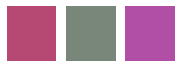

taupe


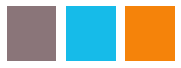

gray blue


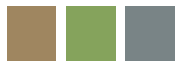

deep teal


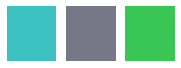

golden brown


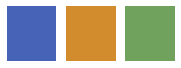

gray green


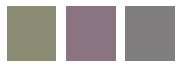

turquoise green


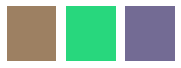

Plain grey


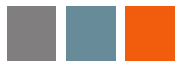

Pale green


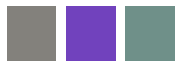

Deep blue


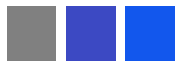

Brown


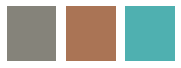

Green


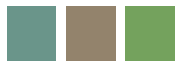

Brownish green


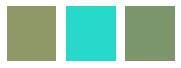

Light purple


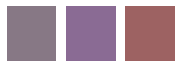

blue gray


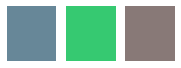

teal


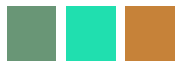

gray


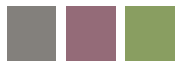

pea green


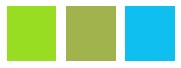

teal gray


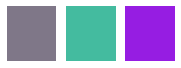

lime green


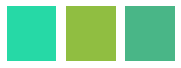

grey blue


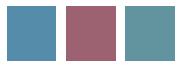

purple red


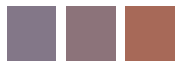

Grey


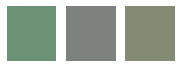

Pale green


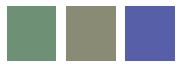

Neon green


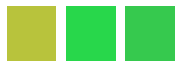

Purple


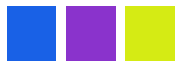

Neon Green


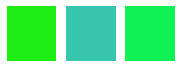

green


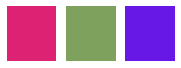

Green


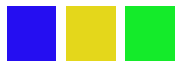

Blue


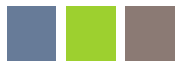

dark blue


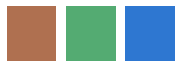

light brown


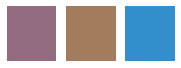

blueish gray


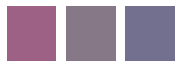

blue green


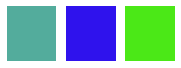

lime green


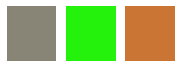

pink


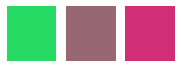

orange


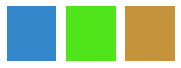

bright orange


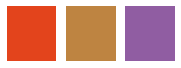

purple gray


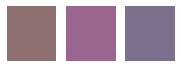

camo green


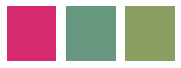

Olive green


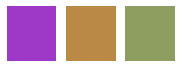

Green


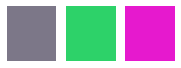

magenta


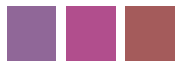

Dark pink


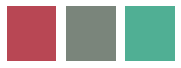

Light purple


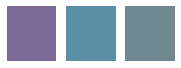

Red


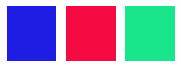

Gray


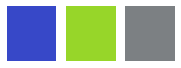

Pink


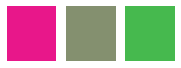

Gray


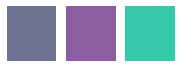

green


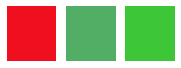

pale blue


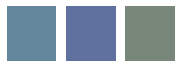

pale blue


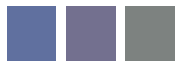

forest green


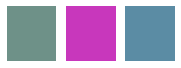

forest green


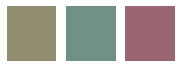

grey


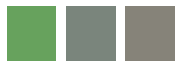

red


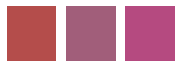

gold


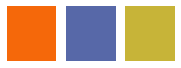

light orange


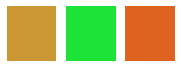

brown


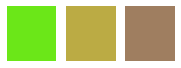

Dark purple


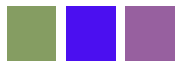

Minty Green


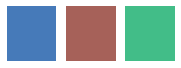

Gray-ish Green


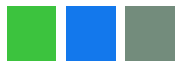

Green with hints of blue


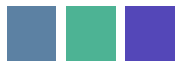

Aquamarine blue, close to the color associated with the brand Tiffany's


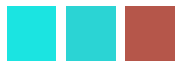

Dark Purple


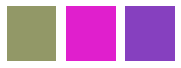

Hot Pink


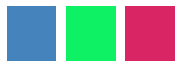

Light brown


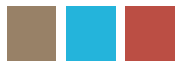

Grey


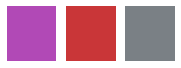

Pea green


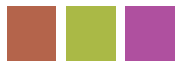

Dull Redish


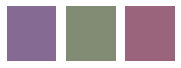

Bright Pink


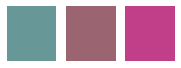

Green


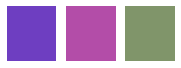

Dull Blue


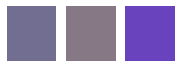

Darker Pea Green


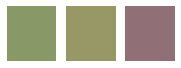

Dark Green


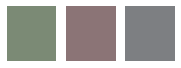

Dull Red


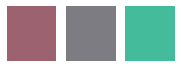

Grey


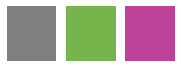

purple


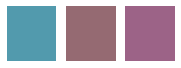

tan


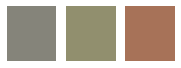

light blue


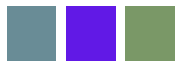

purple


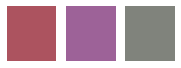

light blue


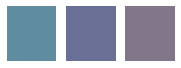

light blue


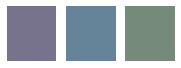

pink


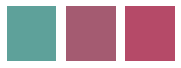

grey


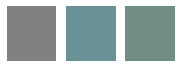

olive


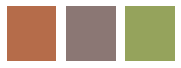

seafoam


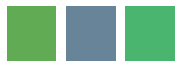

mauve


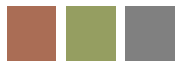

robin egg blue


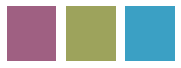

teal


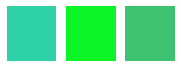

aqua


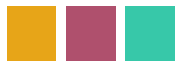

gray


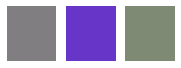

gray


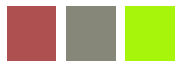

Neon Green


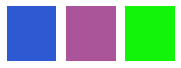

Dark Pink


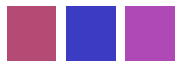

Violet


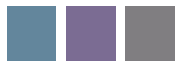

Olive Brown


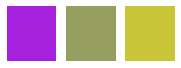

Light Grey


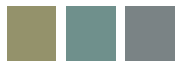

Purple


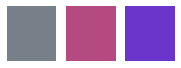

Neon Green


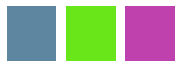

Light Grey


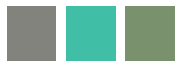

gray


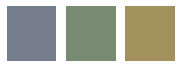

purple pink


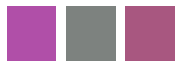

orange


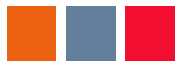

camo green


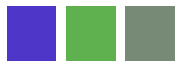

green


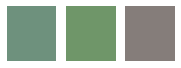

grass green


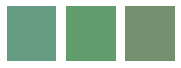

dark purple blue


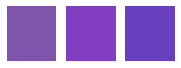

purple


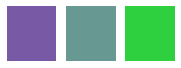

gray green


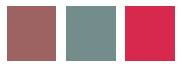

Spring green


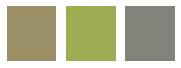

Spring green


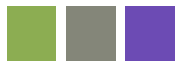

Teal


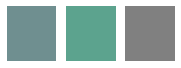

Charcoal gray


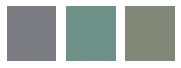

Charcoal gray


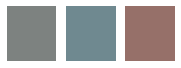

Teal


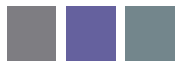

Army light brown


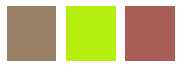

Alabama Crimson Tide red


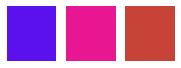

medium gray


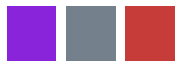

light peach red


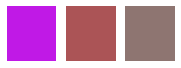

Ferrari red


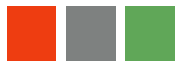

flat purple


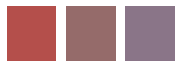

code green


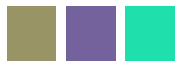

bright green


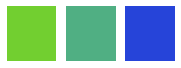

brighter green


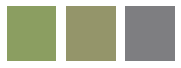

orange


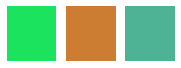

blue


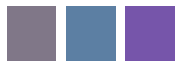

gray


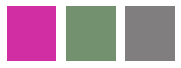

light blue


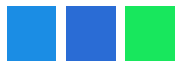

purple


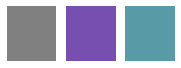

gray


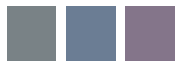

olive tan


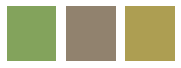

pink


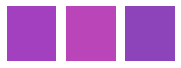

purplish red


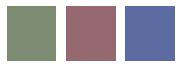

Dark Pink


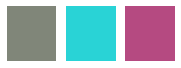

Green Mint


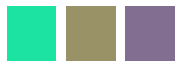

Grey


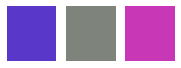

Brown


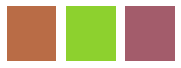

Grey


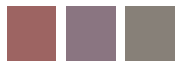

Dark Grey


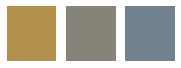

Clear Brown


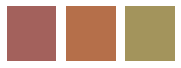

Cyan


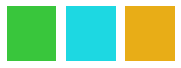

Grey


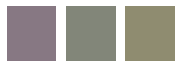

blue green


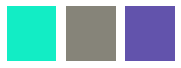

brick red


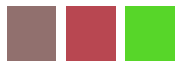

bright red


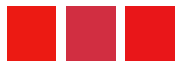

green camo


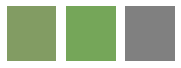

green


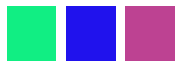

green


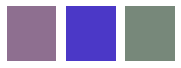

bright green


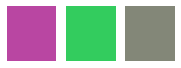

purple red


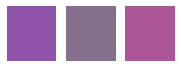

bright orange


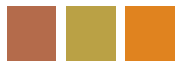

Green


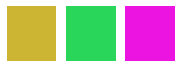

Dark gray


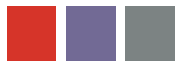

Blue


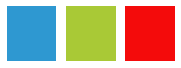

Gray


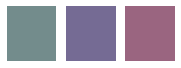

Purple


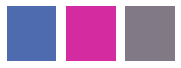

Dark gray


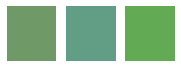

light brown


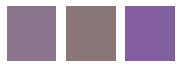

dark green


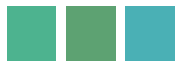

light green


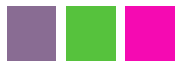

grey blue


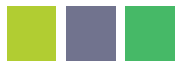

faded light blue


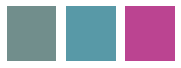

brown


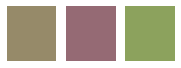

faded blue


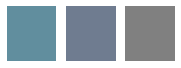

light purple


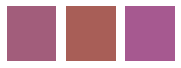

green gray


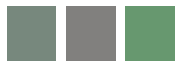

light green


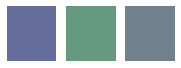

light brown


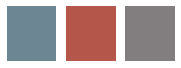

bright purple


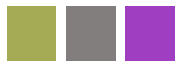

light purple


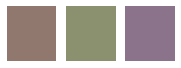

dull green


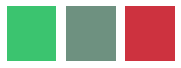

light brown


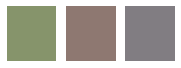

dull green


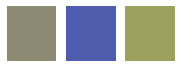

light green


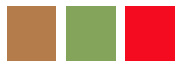

lime


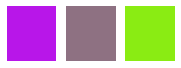

light blue


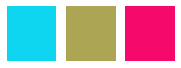

dull green


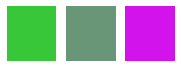

light blue-grey


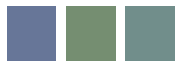

dull lime


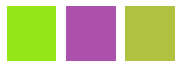

bright green


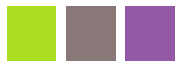

dark orange


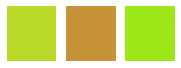

crimson red


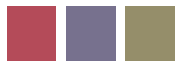

grey


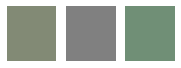

grey


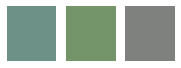

light blue


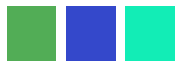

dark blue


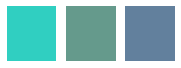

dark green


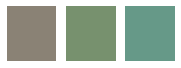

dark blue


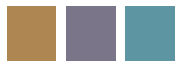

Mint Green


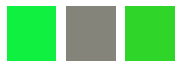

Yellow-Green


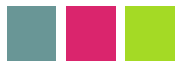

Light Purple


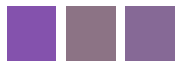

Yellow-Brown


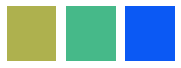

Gray


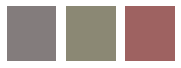

Gray


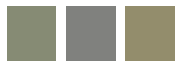

Dark Green


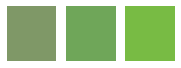

Brown


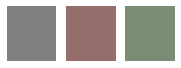

Gray


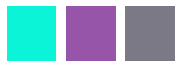

Dark Green


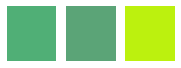

Green


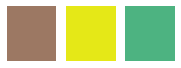

Violet


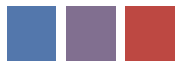

Fucsia


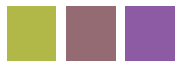

Clear Green


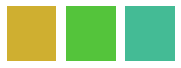

light brown


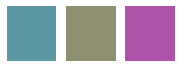

red


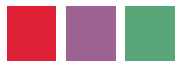

faded blue


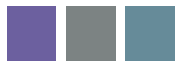

light brown


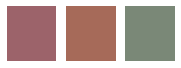

light blue


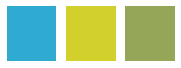

faded green


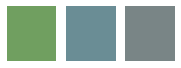

dark pink


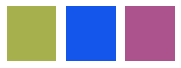

grey


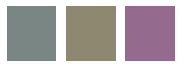

light green


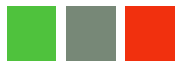

Green


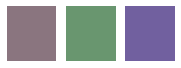

Blue


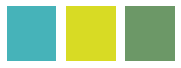

Blue gray


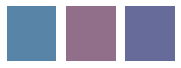

Green


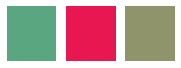

Ochre


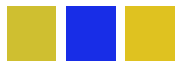

Bright green


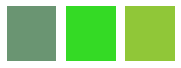

Yellow


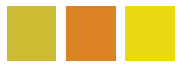

Purple pink


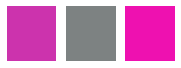

dark purple


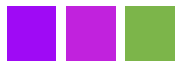

yellow


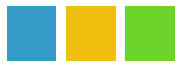

blueish grey


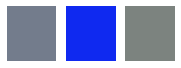

grey


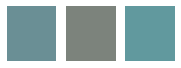

dark grey


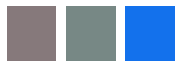

brown


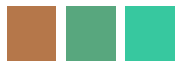

purple


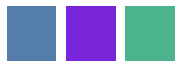

grey


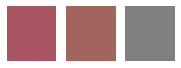

tan


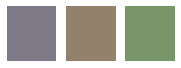

grey


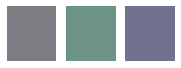

regular blue


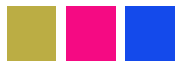

bright teal


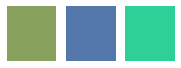

dark grey


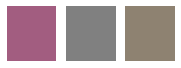

blueish green


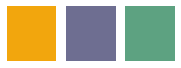

light blue grey


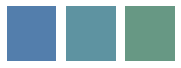

greenish brown


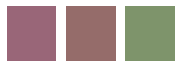

dark orange


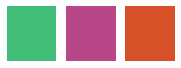

royal blue


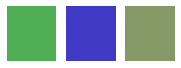

neon green


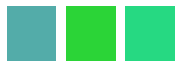

drab olive


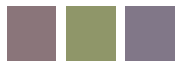

bright purple


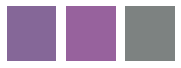

purple


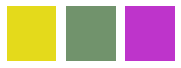

gray


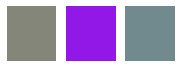

maroon


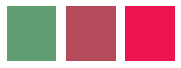

light purple


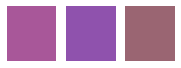

red


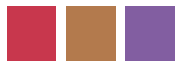

pink


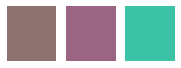

gray


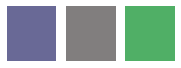

blue


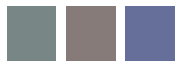

dark pink


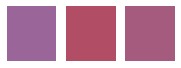

green


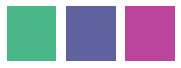

bright orange


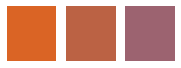

dark pink


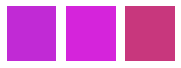

gray


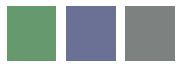

brown


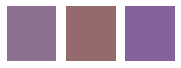

Light green


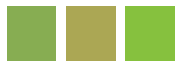

Greenish orange


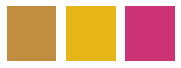

Blueish purple


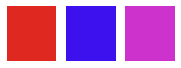

Dark gray


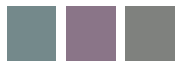

Yellow


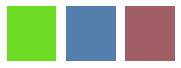

Yellow


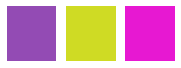

medium green


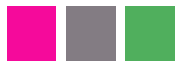

gray


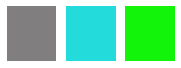

gray


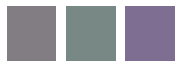

orange


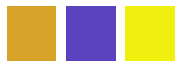

greenish gray


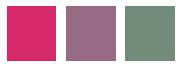

magenta


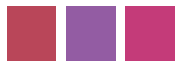

light blue


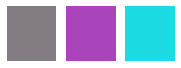

yellowish green


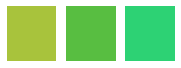

purple


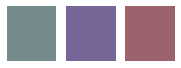

grayish red


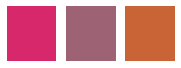

dark purple


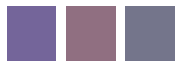

red


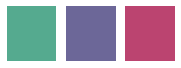

brownish green


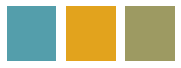

green


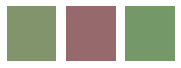

pinkish brown


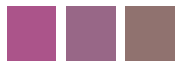

green


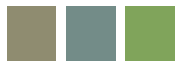

light blue


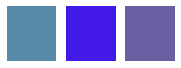

lime green


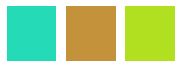

brown


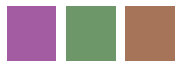

Bright green


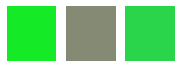

Dark grayish green


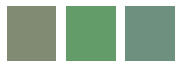

Grayish brown


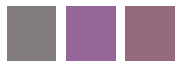

Medium dark blue


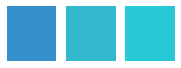

Bright green yellow


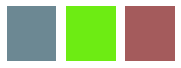

Tan orange


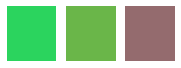

Dark brownish yellow


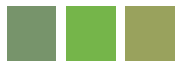

Purple


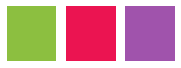

Dark red


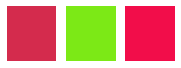

burnt orange


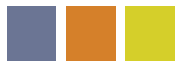

hot pink


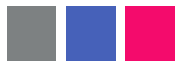

brownish gray


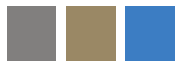

dark blue


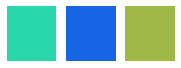

light blue


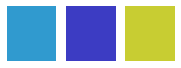

purple


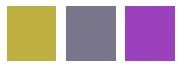

greenish yellow


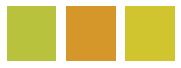

purple


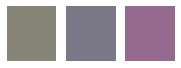

Medium grey


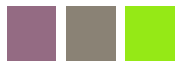

Medium greyish purple


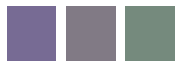

Medium neon green


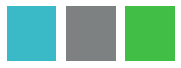

Lightish plum purple


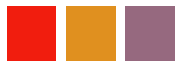

Medium matte grey


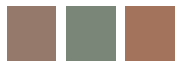

Bluish medium grey


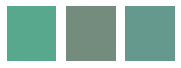

Brownish grey


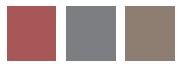

Neon bright pink


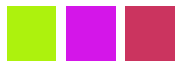

lightish grey


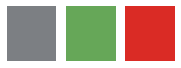

Hot pink


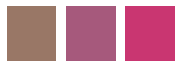

Bluish green


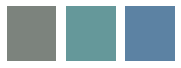

Slate blue


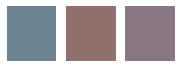

Fuscia


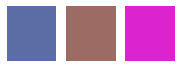

Medium gray


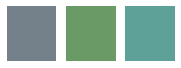

Teal blue


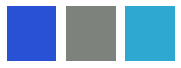

Olive


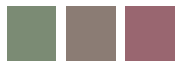

purple grey


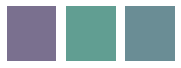

neon green


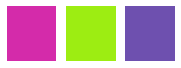

blue


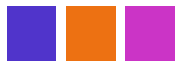

red


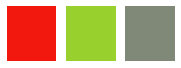

dark purple


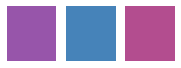

dark blue grey


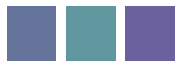

orange


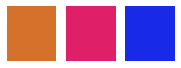

red brown


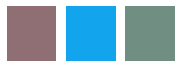

red brown


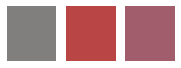

Brighter pink


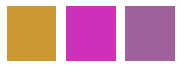

Dark blue


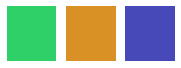

Bluish pruple


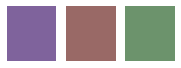

Mauve


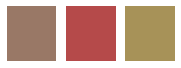

Dull forest green


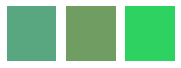

Grey purple


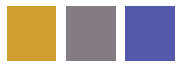

Grey purple


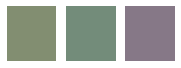

Orangey bron


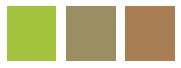

Washed out navy


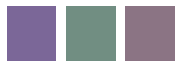

dull green


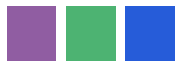

dull orange


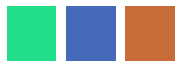

light purple


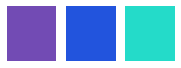

medium aqua


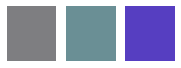

medium plum


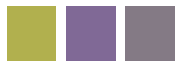

dull gray


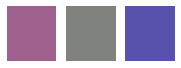

medium green


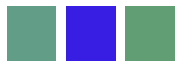

light aqua


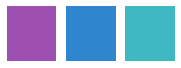

light green


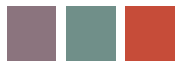

dull green


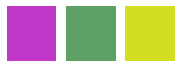

light blue


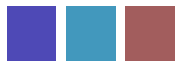

light green


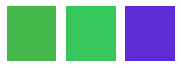

grey blue


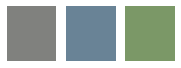

dark blue


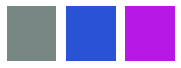

light brown


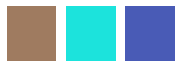

faded red


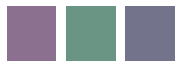

faded brown


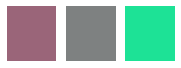

bright pink


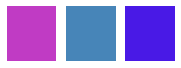

tan


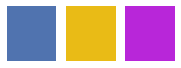

purple


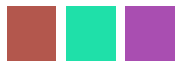

gray


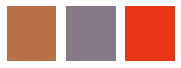

purple


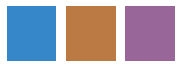

purplish gray


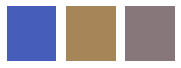

light green


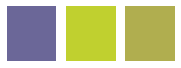

olive green


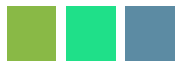

gray


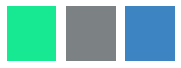

blue


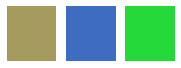

light green


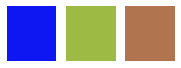

pink


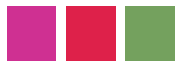

light brown


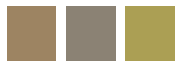

light blue


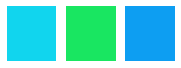

dirty yellow


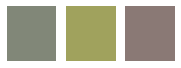

light brown


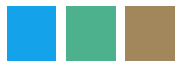

light blue


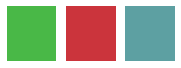

muted brown


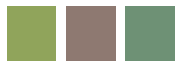

grey-ish green


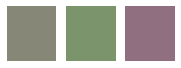

lime green


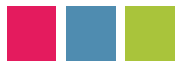

dusky purple


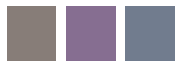

grayish blue


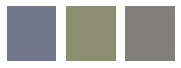

muted red


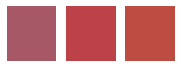

purple


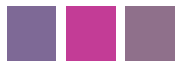

brown


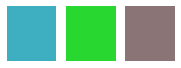

gray


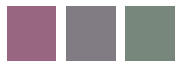

army green


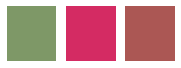

grey


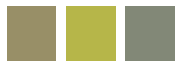

gray


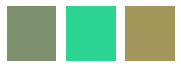

light purple


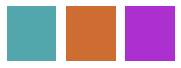

gray


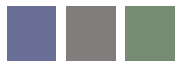

yellow


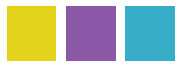

gray blue


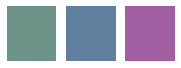

blue gray


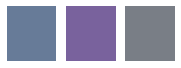

purplish blue


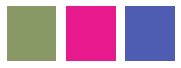

true red


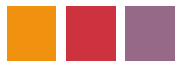

grayish green


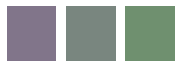

brown


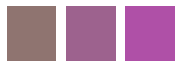

pinkish brown


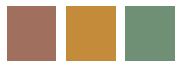

light reddish purple


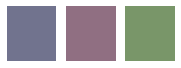

light reddish purple


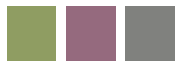

Blueish Gray


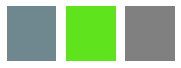

Dark Green


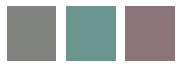

Green


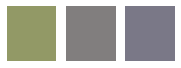

Blueish Gray


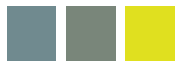

Green


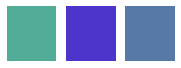

Gray


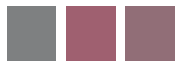

Neon Blue


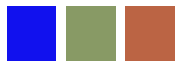

Dark Pink


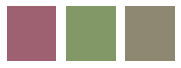

purple


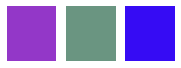

purple


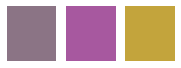

dark blue


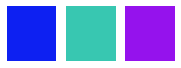

grey


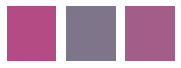

purple


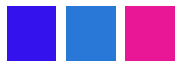

blue


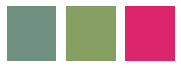

grey


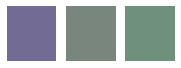

purple


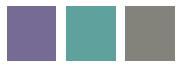

orange


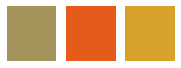

pinkish purple


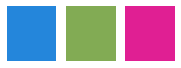

green grey


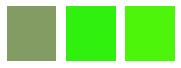

grey


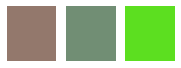

purple pink


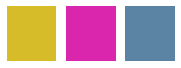

khaki


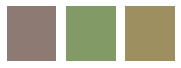

purple grey


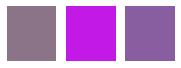

blue grey


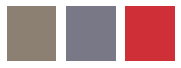

light bright green


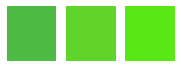

Dark Purple


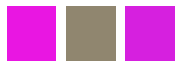

Medium Green


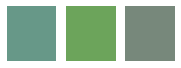

Sky Blue


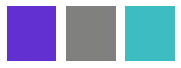

Orange-Yellow


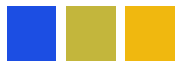

Soft Gray


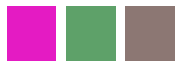

Ordinary Purple


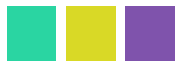

Cobalt Blue


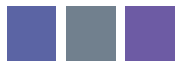

Golden Tan


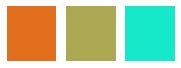

Hot Pink


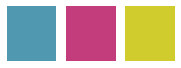

Light Tan


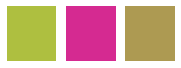

dull peach


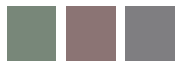

light lime


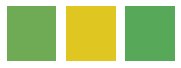

gray


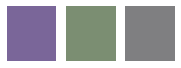

dull red


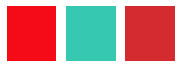

aqua


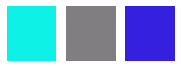

medium purple


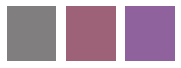

khaki


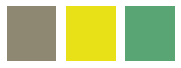

medium slate


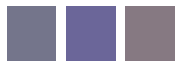

medium blue


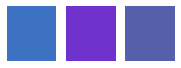

grayish blue


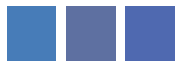

Blue


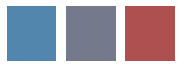

Green


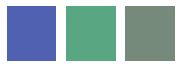

Blue


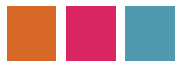

Dark Pink


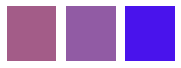

Dark Orange


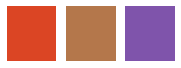

Dark Pink


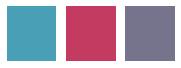

Blue


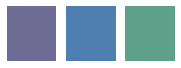

Gray


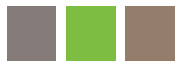

Dark Brown


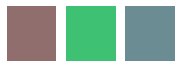

Brown


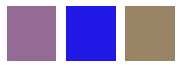

purple


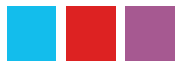

purple


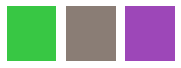

light green


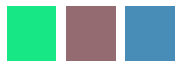

purple


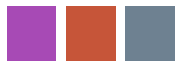

grey blue


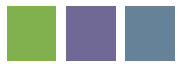

grey purple


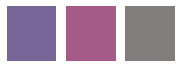

grey


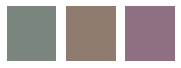

dark red


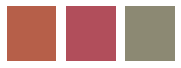

blue


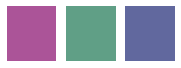

olive green


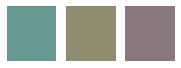

sea green


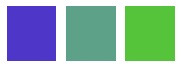

dark green


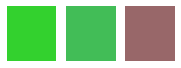

gray


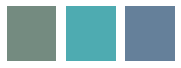

green


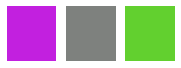

Deep magenta


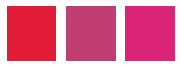

Purple


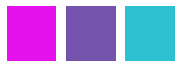

dark green


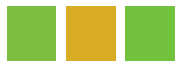

brown


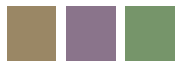

Olive


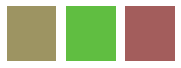

Lighter gray


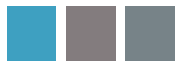

Bright green


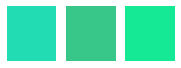

Gray


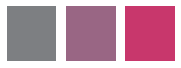

Olive


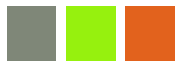

grey


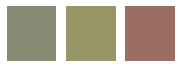

grey


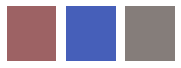

light blue


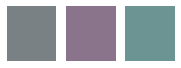

purple


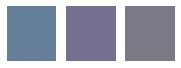

hot pink


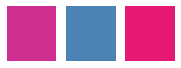

purple


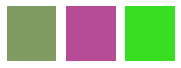

red


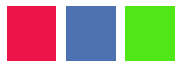

tan


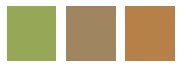

Green


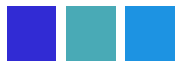

Purple


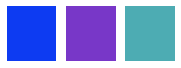

Chocolate


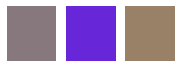

Dark purple


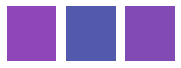

mustard


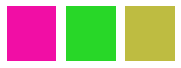

Maroon


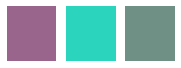

Flashy pink


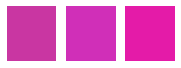

Blue


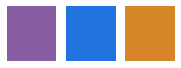

Light Green


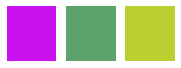

Blue


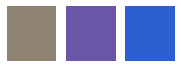

Gray


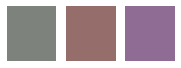

Fucsia


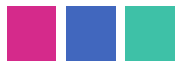

Light Green


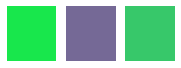

Dark Green


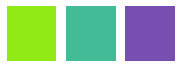

Gray


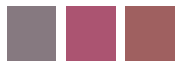

brown


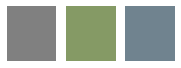

bright green


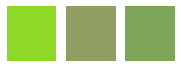

blue


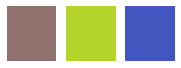

pinkish


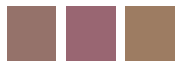

grey


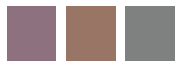

pink


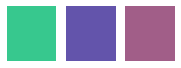

greener


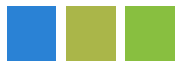

pink


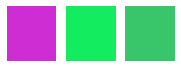

green


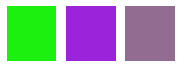

blue gray


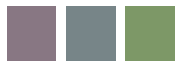

dark blue green


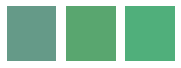

purple


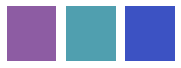

purple


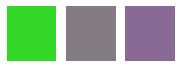

gray


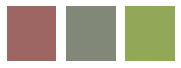

dark yellow greeen


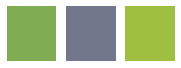

gray


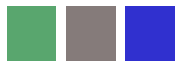

dark purple


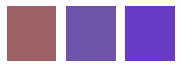

Light Green


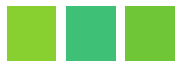

Brown


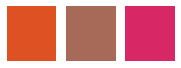

Blue


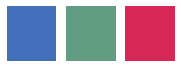

Violet


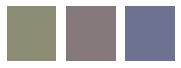

Light Green


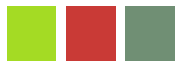

Light Blue


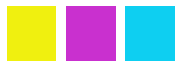

Muted purple


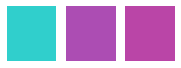

Blue


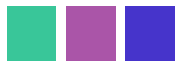

Purplish grey


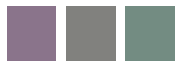

Golden brown


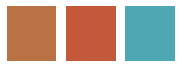

Turquoise


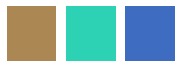

Fern green


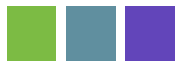

Khaki


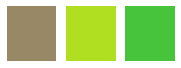

Dark grey


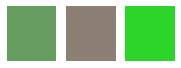

Bright purple


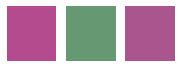

dark blue


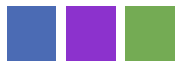

grey


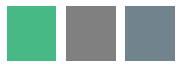

light brown


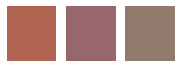

dark blue


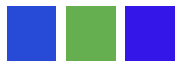

grey


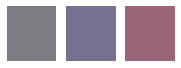

faded brown


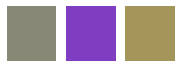

light brown


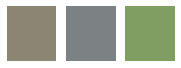

gray


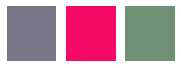

purplish red


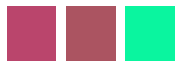

avocado


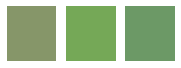

purplish gray


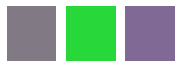

purple


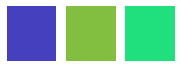

light brown


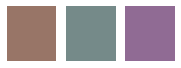

dark pink


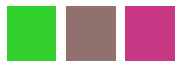

light dusty green


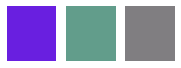

light blue


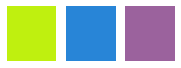

khaki


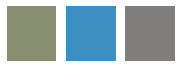

greenish brown


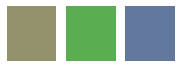

green


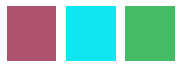

dark purple


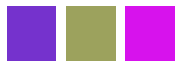

gray


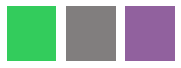

teal


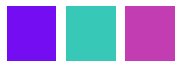

brown


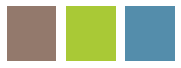

gray


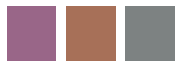

pink


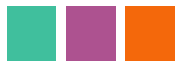

grayish sand like color


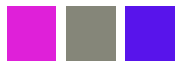

brown


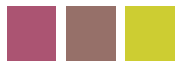

pinkish brown


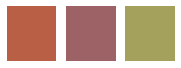

turquoise


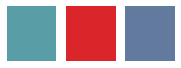

sandy brownish


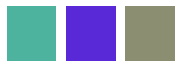

red


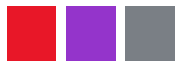

purple


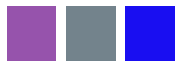

duller less vibrant blue


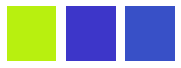

salmon reddish


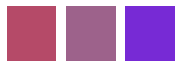

brightest and yellowest


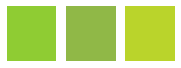

green


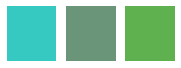

brick red


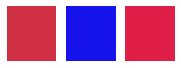

purple


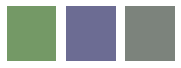

gray


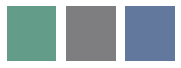

blue


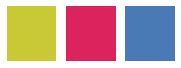

light blue


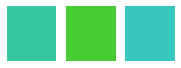

blue


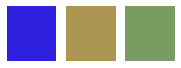

orange


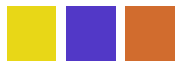

brown


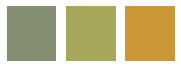

less gray purple


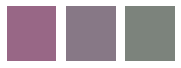

purple


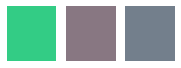

light blue


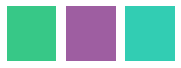

grey


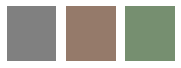

green


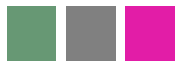

purple


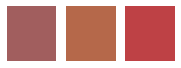

green


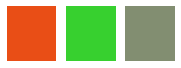

purple


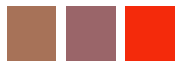

tan


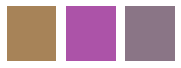

grey


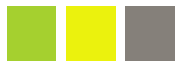

Charcoal gray


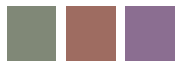

Charcoal gray


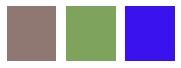

Holiday green


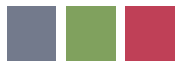

Turquoise


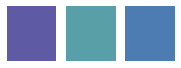

Dark yellow


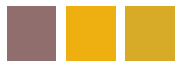

Purple


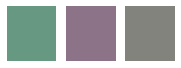

Pink


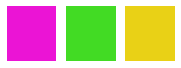

Forest Green


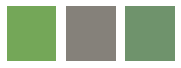

Dark Green


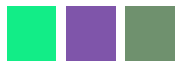

Orange


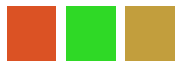

Red


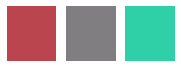

Dark Green


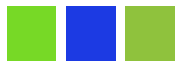

Forest Green


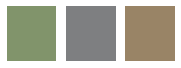

Hot Pink


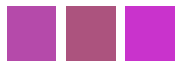

gray


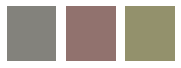

light purple


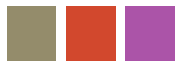

gray


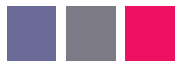

khaki


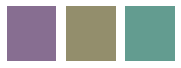

khaki


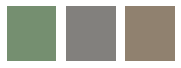

lavender


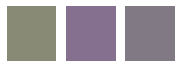

salmon


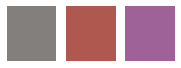

light green


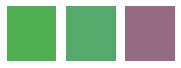

sky blue


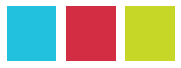

cyan


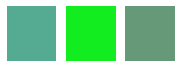

gray


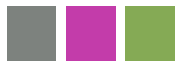

neon purple


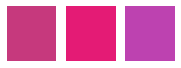

neon green


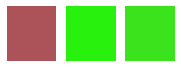

purple


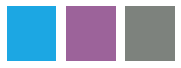

dull yellow


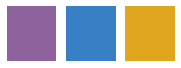

bright blue


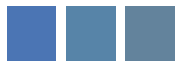

medium green


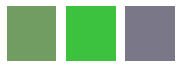

dull orange


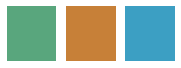

rust


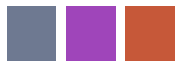

yellowish orange


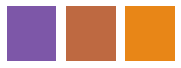

dull gray


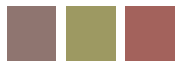

slate


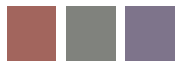

blue gray


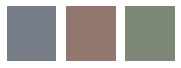

gray brown


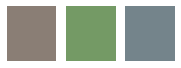

dark seafoam green


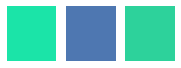

pink


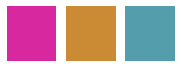

reddish pink


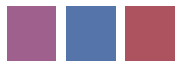

pinkish purple


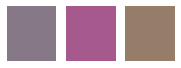

gray


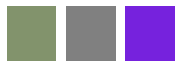

red brown


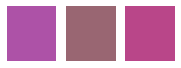

blue


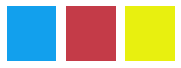

candy green


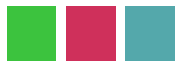

light magenta


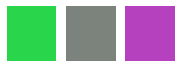

algea green


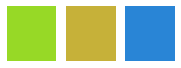

gray brown


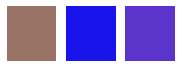

light gray brown


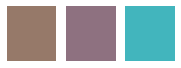

faded tan


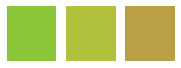

gray


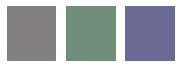

drab gray


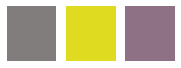

dull blue


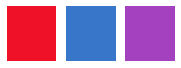

Greenish-Yellow


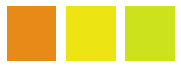

Medium-Gray


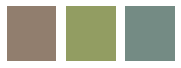

Aqua Blue


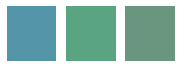

Dusty Gray


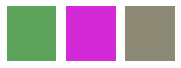

Dull Purple


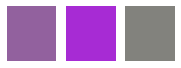

Straight Gray


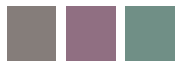

Grayed-Purple


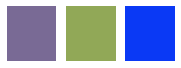

Light Purple


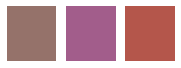

Dark Teal


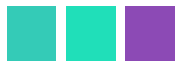

tan


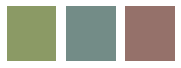

dark green


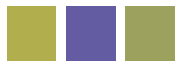

light blue


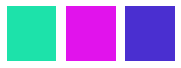

blue


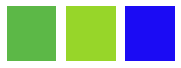

blueish purple


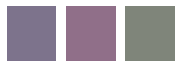

pink


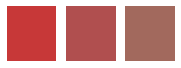

light grey


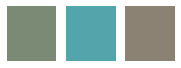

grey


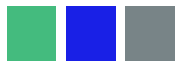

grey


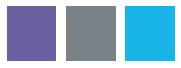

light brown


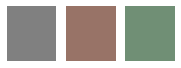

light green


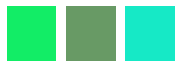

green


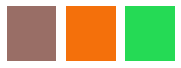

light brown


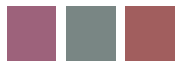

light maroon


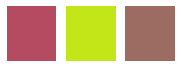

lilac


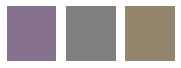

turqoise


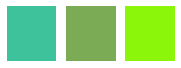

light orange


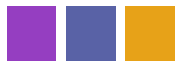

orange


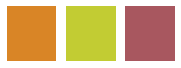

sky blue


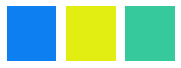

gray


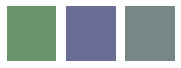

green


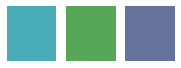

purple


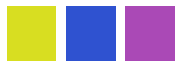

camo green


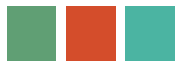

sunny yellow


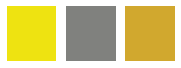

bright purple


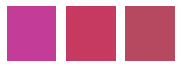

gray


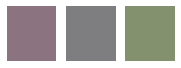

camo green


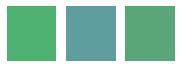

Dark Pink


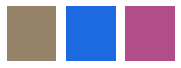

Green


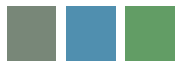

Green


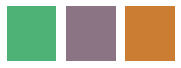

Neon Blue


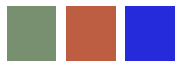

Cyan


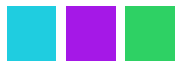

Dark Violet


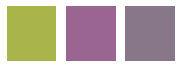

Dark Pink


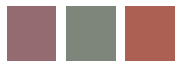

Light Purple


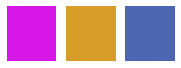

Pale Green


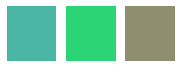

Deep Red


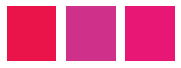

Beige Gray


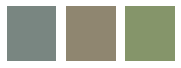

Burnt Orange


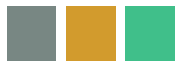

Deep Sea Blue


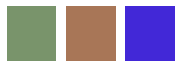

Blurple


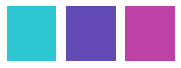

Magenta Purple


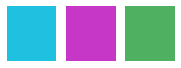

Deep Blue


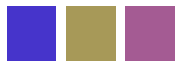

Gray


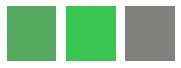

grey


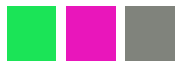

dark red


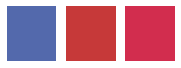

grey blue


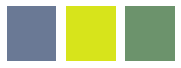

true grey


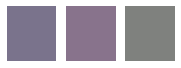

yellow


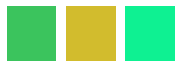

purple


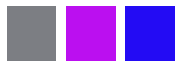

blue


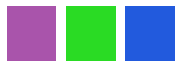

neon green


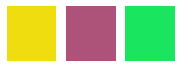

yellow


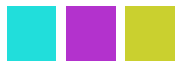

dull grayish blue


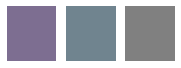

aqua


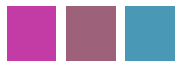

aqua


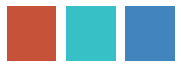

dull reddish pink


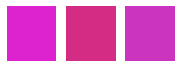

light red


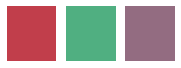

dull aqua


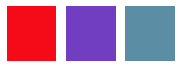

grayish blue


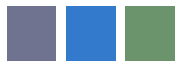

aqua


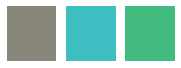

dull lime


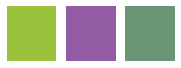

tan


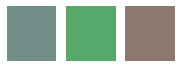

Dark grey


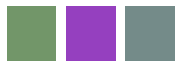

green


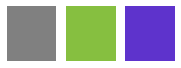

olive green


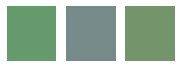

sky blue


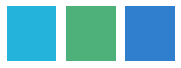

brownish grey


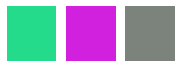

grey


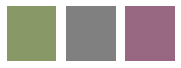

blue


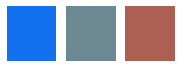

grey


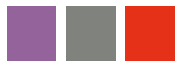

purplish grey


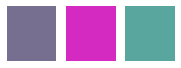

greyish blue


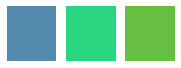

pink


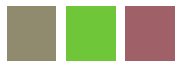

purple


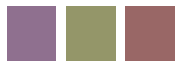

light green blue


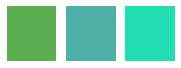

dark green gray


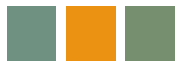

purple


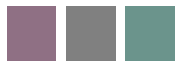

orange


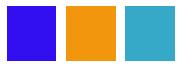

green


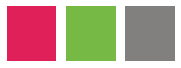

gray pink


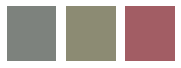

dark brown


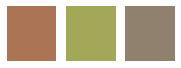

orange


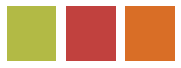

grey


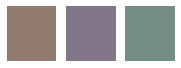

light purple


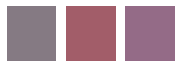

dark green


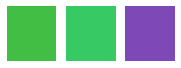

purple


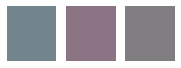

darker brown


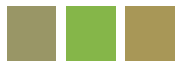

blue/purple


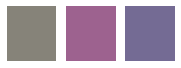

dark blue


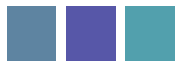

Gray


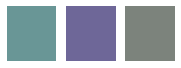

Gray


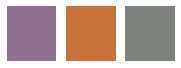

Hot red


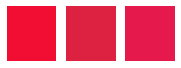

Purple


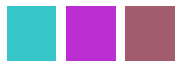

Brownish Orange


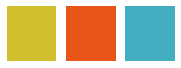

Forest Green


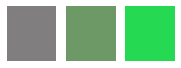

Reddish Brown


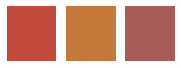

Light Brown


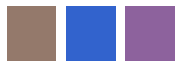

Gray


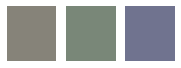

dull green


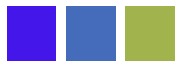

gray


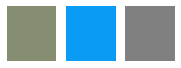

meium purple


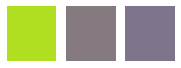

aqua


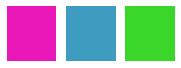

medium plum


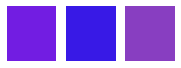

dull pink


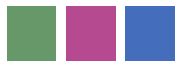

tan


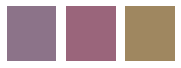

medium green


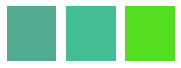

dull aqua


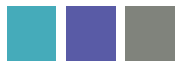

dull slate


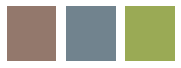

Mauve


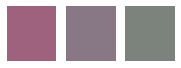

Blue


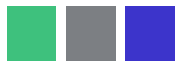

Brown


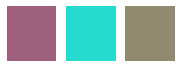

Purple


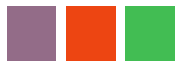

Green


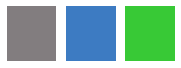

purple


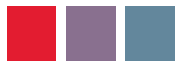

Light blue


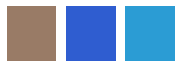

Hot pink


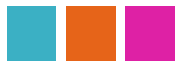

Coral


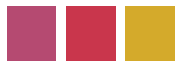

teal


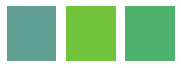

flat purple


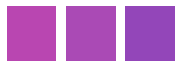

grey


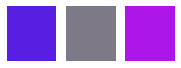

pinkish grey


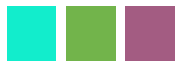

steel blue


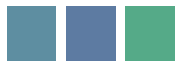

grey


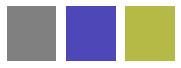

slime green


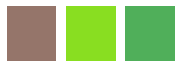

faded purple


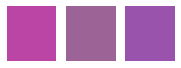

grey purple


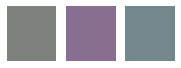

grey


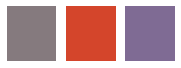

light green


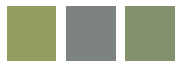

dark green


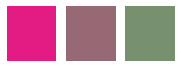

brown


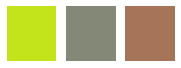

purple


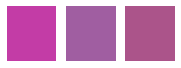

grey


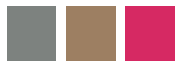

grey


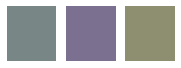

smoke grey


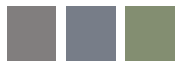

pink


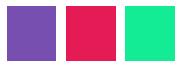

dark green


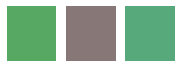

Brown


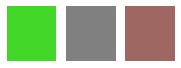

Gray


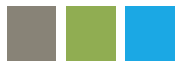

Dark brown


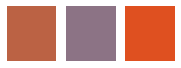

Purple


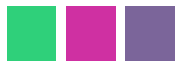

Gray


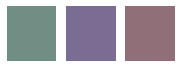

Lemon Green


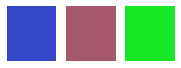

orange


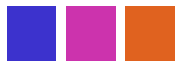

brown


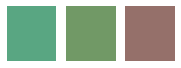

grey brown


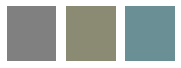

dark blue


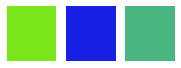

green brown


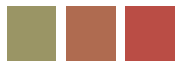

lime green


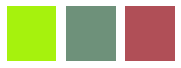

grey brown


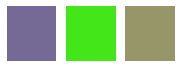

light grey


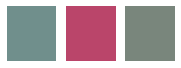

red orange


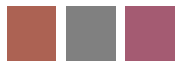

light green


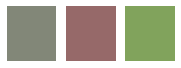

Bright green


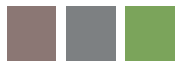

Yellow


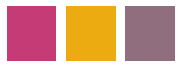

Greenish/yellow grey


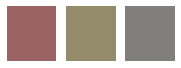

Slate Blue


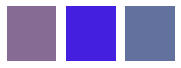

Bright purple


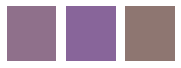

Grey


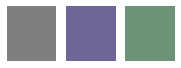

Blue


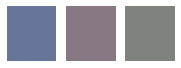

Brown


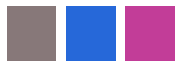

Red


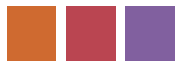

Bright blue


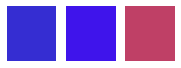

blue


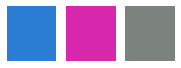

purple


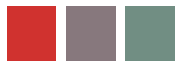

red


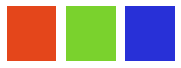

purple-blue


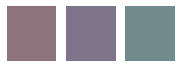

gray


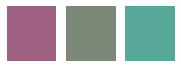

turquoise


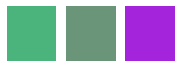

gray


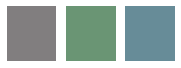

blue-green


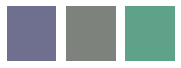

purple


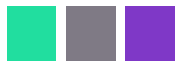

Light green


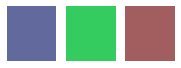

Army green


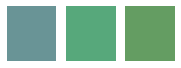

gray


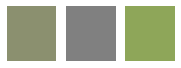

gray


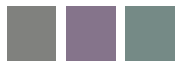

Greeen


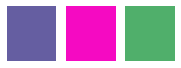

purple


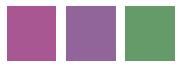

green


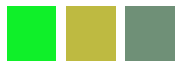

neon green


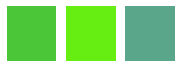

medium purple


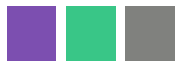

leaf green


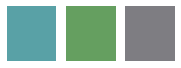

medium blue


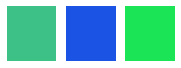

medium charcoal


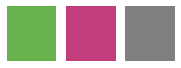

pea yellow


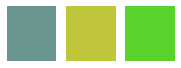

light brown


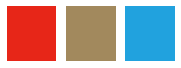

medium brown


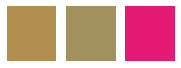

pea


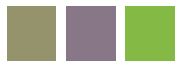

pea


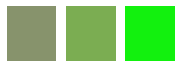

burnt orange


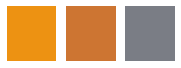

dim pink


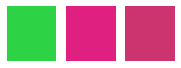

greenish khaki


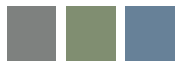

grey


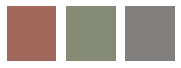

grey


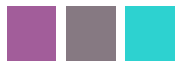

dim orange


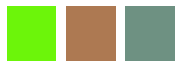

dim light purple


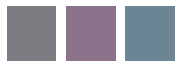

dim pink


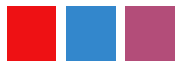

medium green


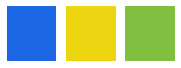

green


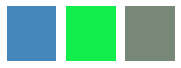

gray


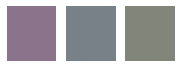

orange


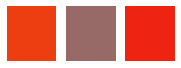

dull blue


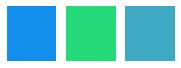

green


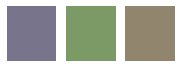

red


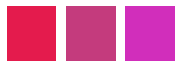

brown


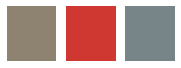

green


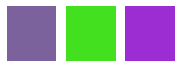

medium-light blue


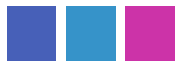

dark pink


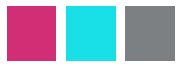

forest green


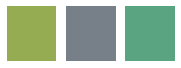

medium-dark green


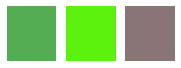

forest green


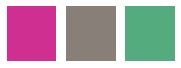

dark blue


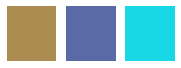

reddish brown


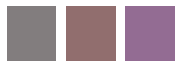

light rust orange


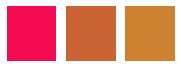

camo green


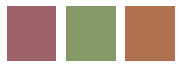

Gray


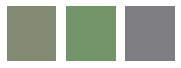

Green


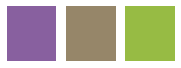

Dark Blue


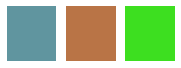

Vivid Purple


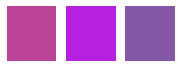

Violet


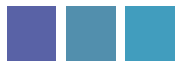

Blueish Green


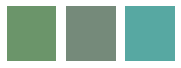

Dark Orange


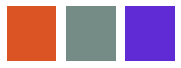

Dark Pink


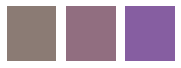

Mint green


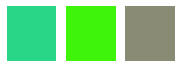

Green


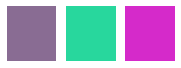

Bright green


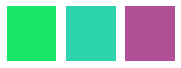

Darker purple


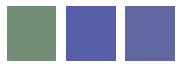

Purple gray


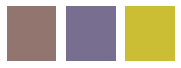

Purple


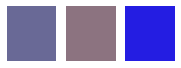

Blue


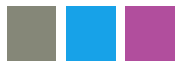

Light maroon


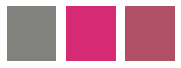

Royal blue


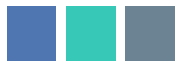

Red


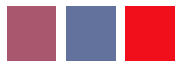

Light brown


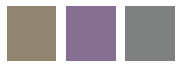

Brown


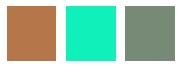

Green


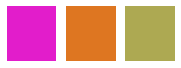

Violet


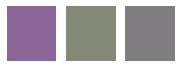

Violet


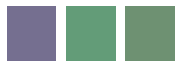

Green


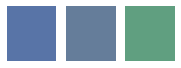

Dark Pink


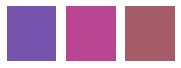

Green


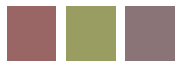

Gray


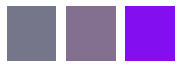

bright yellow


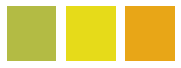

grey


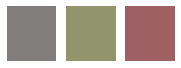

purple


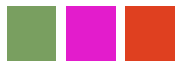

light blue


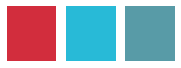

blue grey


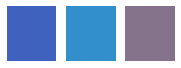

red brown


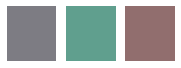

brown


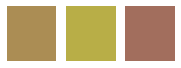

olive green


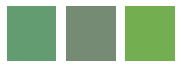

gray


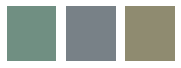

teal


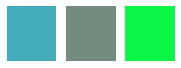

brown


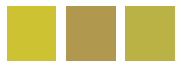

green


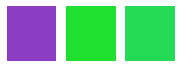

brown


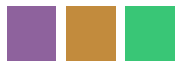

dark blue


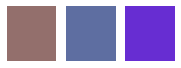

light neon green


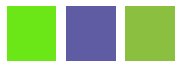

green


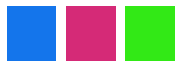

orange


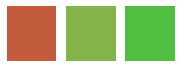

dark rose red


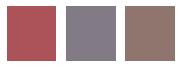

yellow


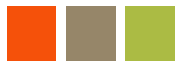

yellow


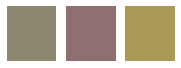

green


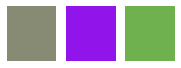

dark blue grey


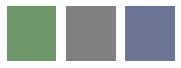

blue grey


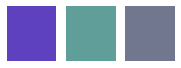

purple


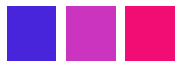

pink


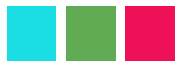

brighter purple


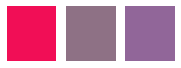

purple


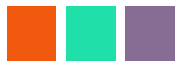

brownish gray


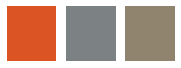

more muted blue


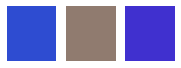

light blue


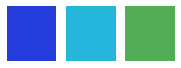

purple


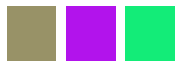

gray


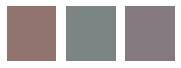

blue


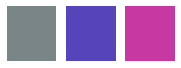

purple blue


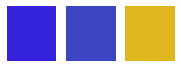

olive


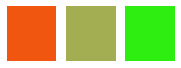

grey green


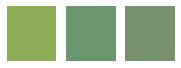

lavender


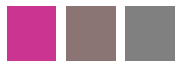

bright purple


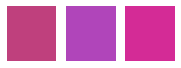

lavender


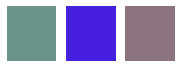

tan


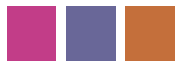

Light purple


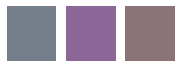

Light orange


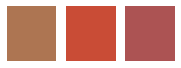

Green


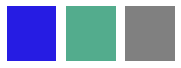

Dark grayish cyan


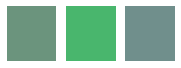

Dark yellow


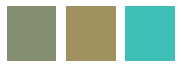

Deep purple


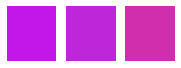

Grayish blue


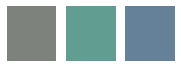

Dark brownish yellow


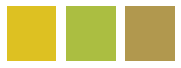

Dark yellow


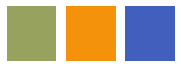

brown


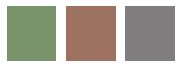

purple pink


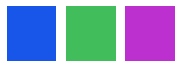

dark blue green


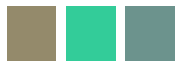

dark blue


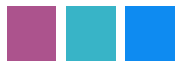

dark red


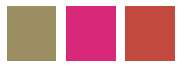

dark yellow


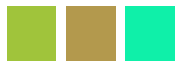

dark gray


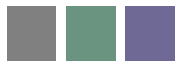

bright green


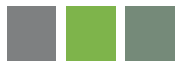

yellow


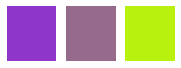

grayish green


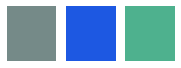

true blue


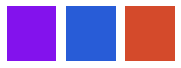

light grayish blue


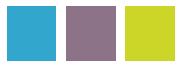

blueish lime green


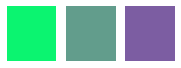

brownish red


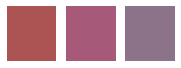

apple red


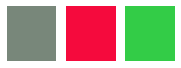

reddish gray


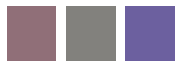

grayish blue


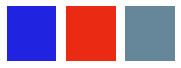

orange


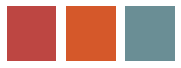

green


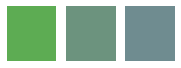

salmon


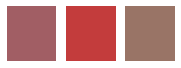

gray


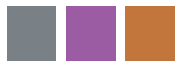

mauve


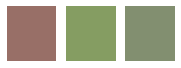

robin egg blue


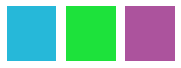

yellow-green


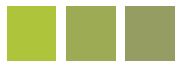

lime


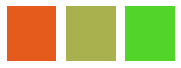

grey


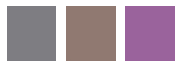

red


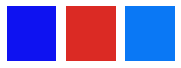

orange


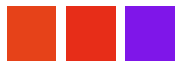

lime


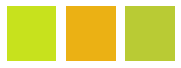

leaf green


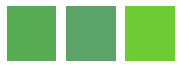

bright purple


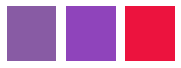

purple


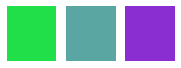

puce


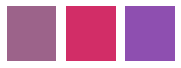

brown gray


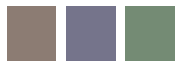

light purple


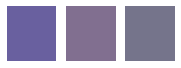

slab green


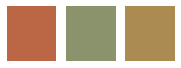

gray


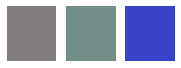

faded green


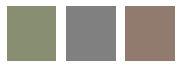

pink purple


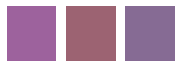

gentle gray


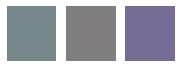

soft green


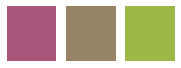

baby blue


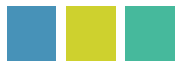

beige


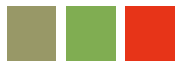

dull purple


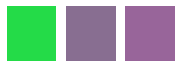

yellow


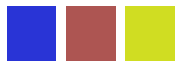

green grey


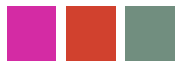

grey


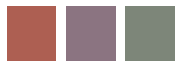

teal


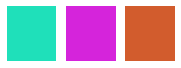

teal


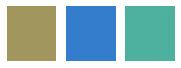

orange


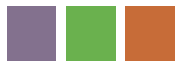

purple


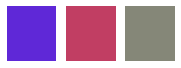

grey


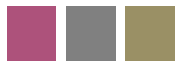

normal grey


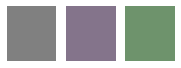

brownish


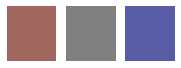

lime green


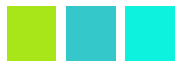

sandy beigeish


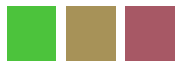

most purple


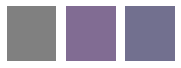

blue


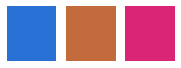

purpley grey


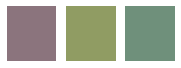

darkest purple


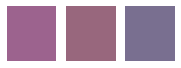

green-blue


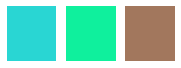

dull green


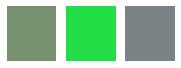

dull purplish blue


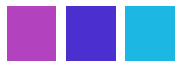

dim purplish blue


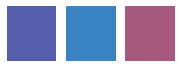

dull lime


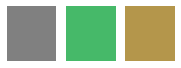

medium lime


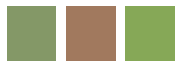

pinkish peach


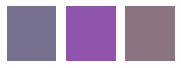

aqua


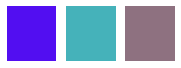

tan


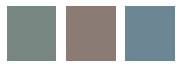

dull purple


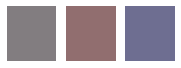

dull green


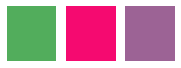

lime green


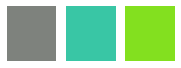

pale plum


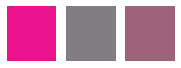

bright lime


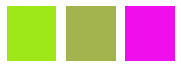

pale orange


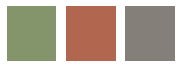

medium plum


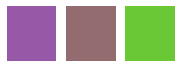

bright purple


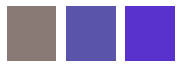

dull green


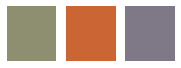

dull orange


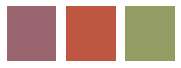

light green


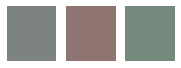

plum


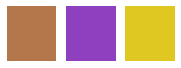

chocolate brown


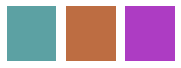

muted teal


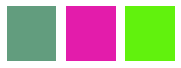

sea green


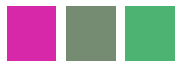

orange


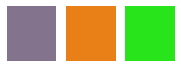

light purple


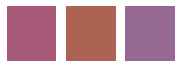

slate blue


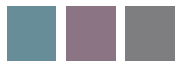

medium grey


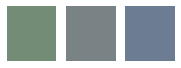

purple


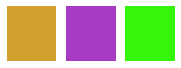

medium gray


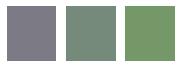

fuschia


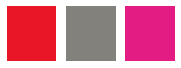

Hot pink


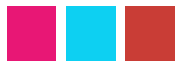

Warm red


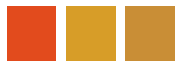

Reddish Orange


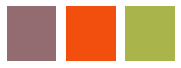

Blue


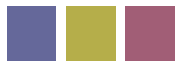

Maroon


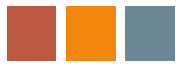

Blueish gray


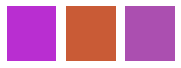

light brown


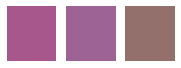

blue


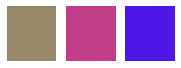

gray


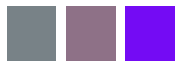

purple


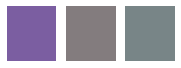

dull green


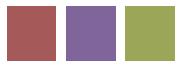

gray


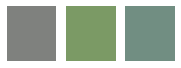

green


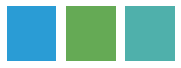

blue


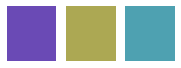

purple


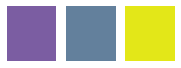

dark pink


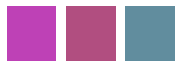

grayish brown


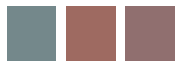

red


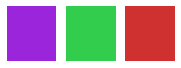

red


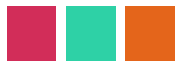

lighter blue


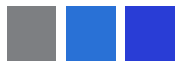

red


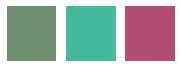

royal blue


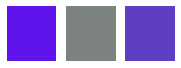

green


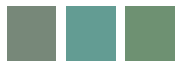

green


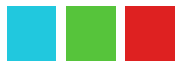

raspberry pink


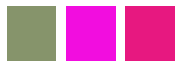

brown


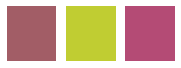

orange


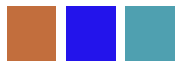

yellow


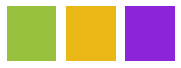

purple grey


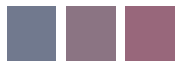

bright purple


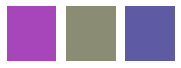

grey


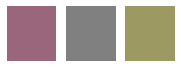

brown


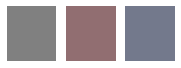

bright blue green


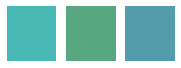

true purple


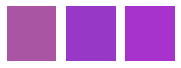

green


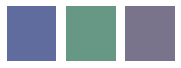

dark blue


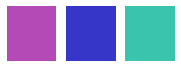

gray


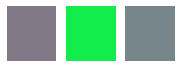

brown


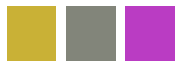

glare green


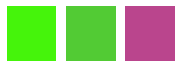

cyan


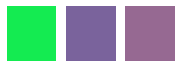

light gray


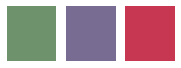

violet gray


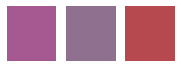

mixed violet gray


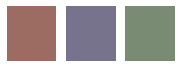

Dark grey


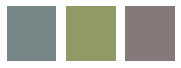

Blue grey


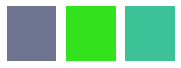

Purple


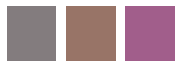

Grey


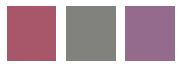

Yellow


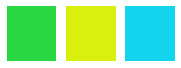

Yellow green


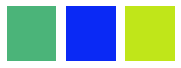

Purple


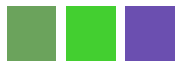

Brown


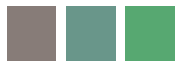

dark green


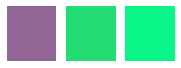

light blue


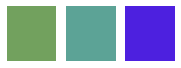

dark blue


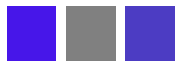

hot green


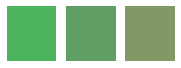

dark pink


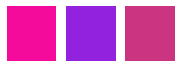

light blue


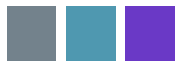

purple


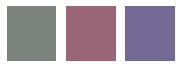

hot orange


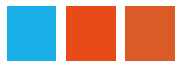

pink


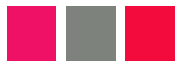

gray


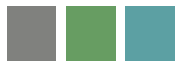

purple


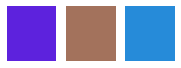

gray-brown


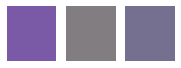

brown


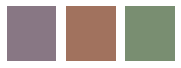

green


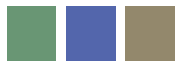

yellow


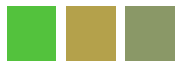

pale teal


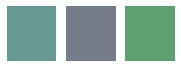

Neon green


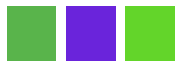

pale green


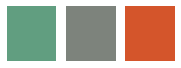

gray


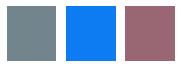

red


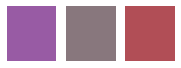

brownish green


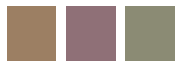

greenish blue


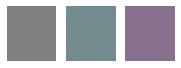

brownish red


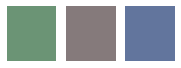

blue


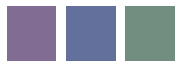

yellow


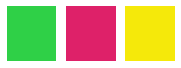

purple


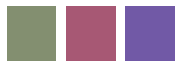

mauve


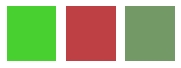

blue-gray


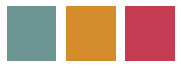

pale green


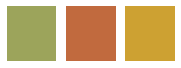

teal


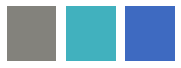

light brown


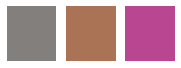

aqua


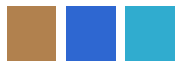

gray


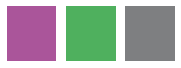

Mustard


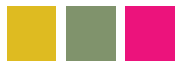

Brighter green


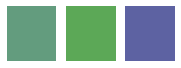

Brown


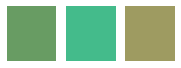

Brighter brown


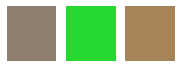

Dark gray


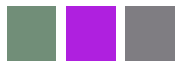

Olive


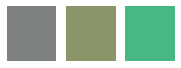

Orange rust


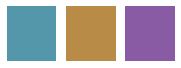

Dull blue


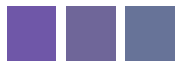

Grey


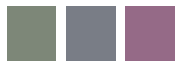

Light Brown


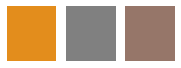

Red


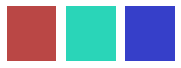

muted suede brown


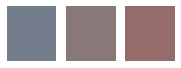

Olive Green


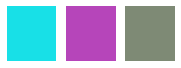

More vibrant olive green


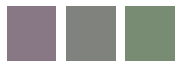

orange


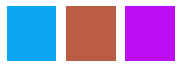

slightly vibrant purple


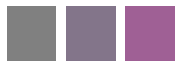

darker violet


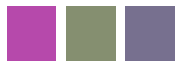

lime green


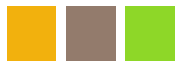

mauve


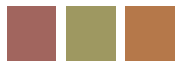

dandelion


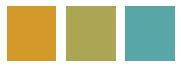

soft purple


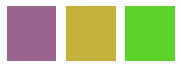

khaki


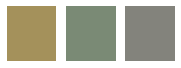

magenta


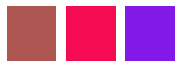

gray


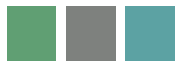

gray


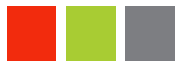

salmon


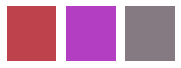

blue-gray


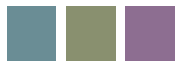

purple


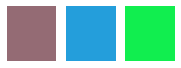

light blue


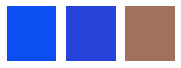

purple


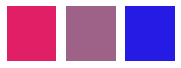

yello


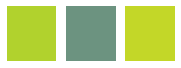

dark purple


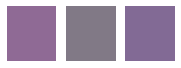

grey


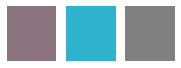

tan green


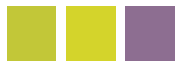

tan


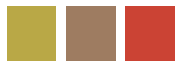

stone gray


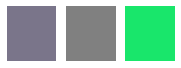

puke green


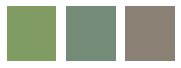

dark grey


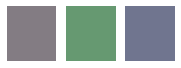

grayish green


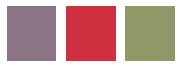

tan yellow


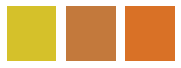

purple gray


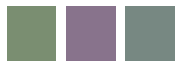

Dark Grape


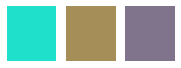

Medium Gray


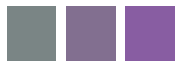

Burnt Yellow


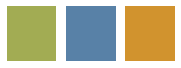

Trunk Brown


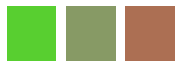

Dark Gray


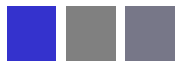

Sky Red


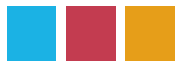

Greenish Brown


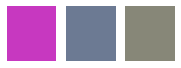

Leaf Green


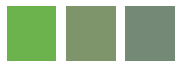

Hot Pink


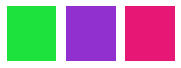

Light Green


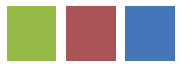

LIght green


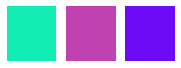

Gray


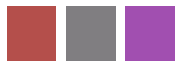

Claret


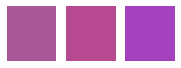

Maroon


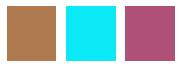

Dark green


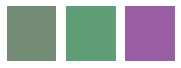

Dark gray


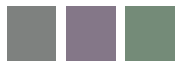

Red


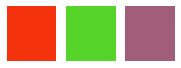

Maroon


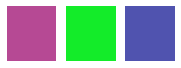

Teal


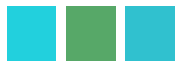

Purplish grey


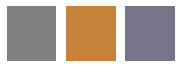

Mustard yellow


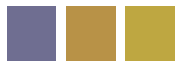

Light purple


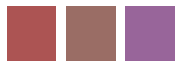

Plain grey


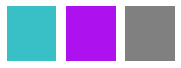

Pale purple


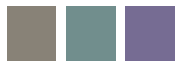

Bright Purple


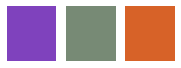

bright green


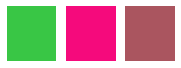

Light purple


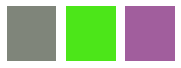

Light tan


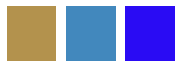

Dark yellowish-green


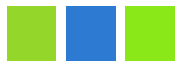

Hot pink


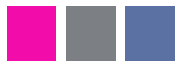

Light blue


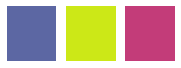

Grayish purple


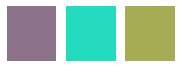

Blue green


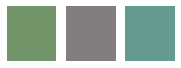

Light brownish red


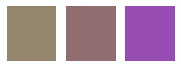

Cyan


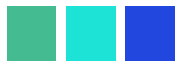

Mustard yellow


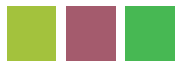

gray


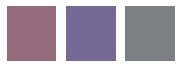

blue


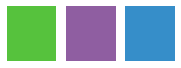

purple


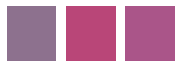

light green


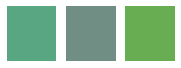

light blue


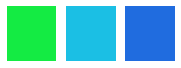

brown gray


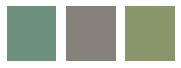

lime green


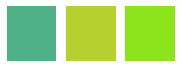

dark blue


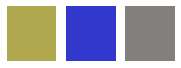

yellow


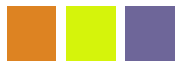

blue gray


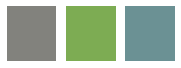

green gray


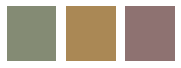

purple


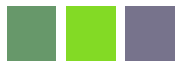

purple


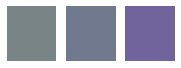

dark green


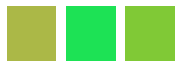

brown purple


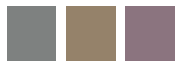

green


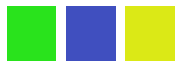

green gray


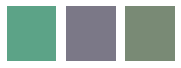

yellow


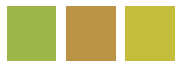

light green


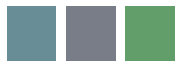

purple


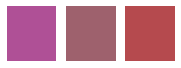

blue


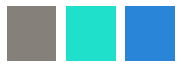

grey


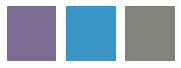

grey


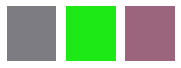

grey


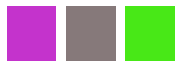

orange


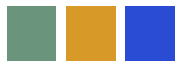

Dark purple


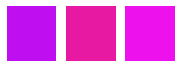

Green


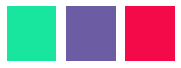

Forest green


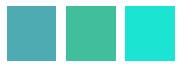

Neon green


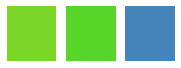

Grey


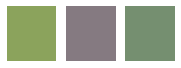

Grey


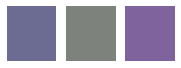

Light brown


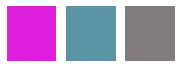

Bright green


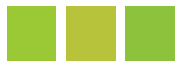

Dark purple


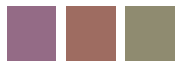

Light purple


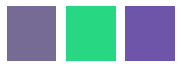

green yellowish color


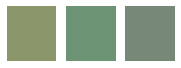

deep purple


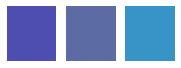

grey


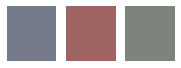

puke green


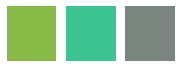

purple


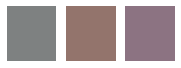

green


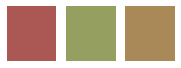

true red


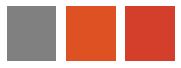

yellow


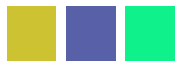

Dark Pink


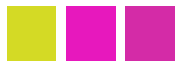

Deep Purple


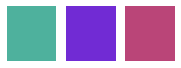

Dark Aqua


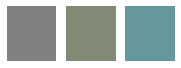

Medium Blue


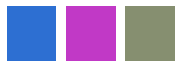

Blueish Purple


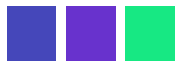

Dark Pink


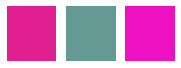

Grey Blue


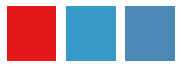

Medium gray


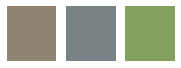

dark gray


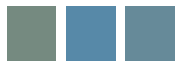

turquoise


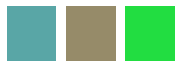

light green


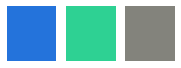

green


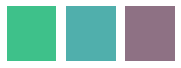

dark gray


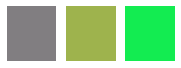

greenish gray


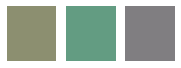

purple


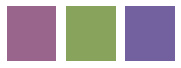

Purple gray


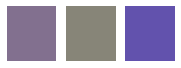

gray


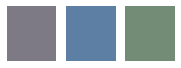

light brown


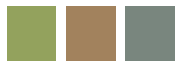

light pink


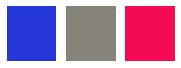

lime green


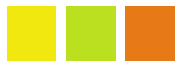

dark orange


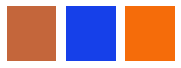

olive green


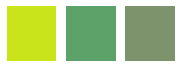

light blue


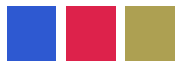

army green


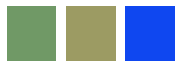

vibrant purple


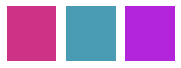

darker blue


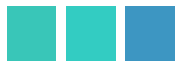

fuschia pink


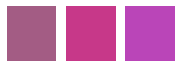

traditional grey


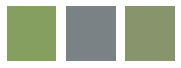

light pink red


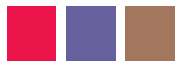

brown


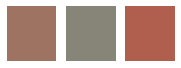

blue


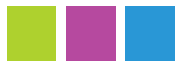

purple


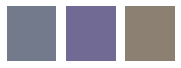

gray/green


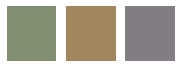

orange rust


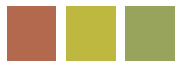

dull bluish purple


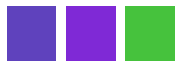

purplish gray


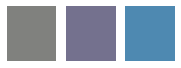

dull green


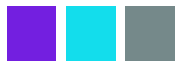

bright green


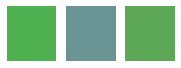

gray


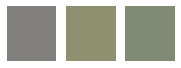

light brown


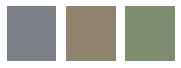

dull pink


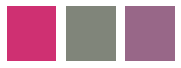

dull green


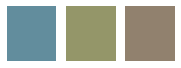

bright lime


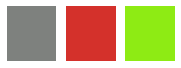

gray


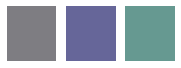

Gray


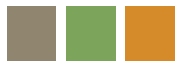

Brown


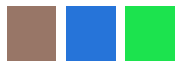

Olive green


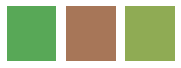

Light green


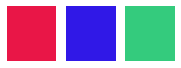

Yellow


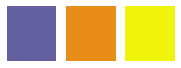

Dark green


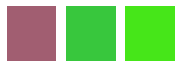

Magenta


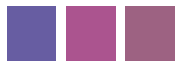

olive green


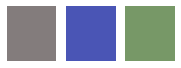

yellow


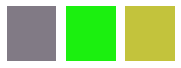

gray


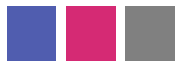

faded red


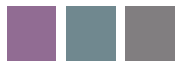

faded red


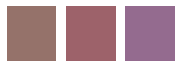

faded green


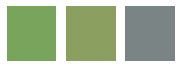

light purple


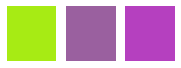

faded green


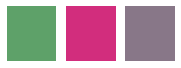

light green


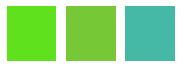

brown green


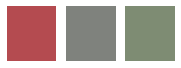

faded purple


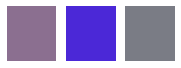

pink


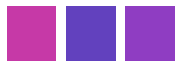

bluish gray


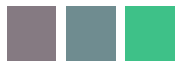

lighter gray


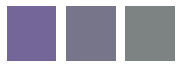

blue


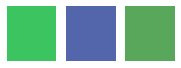

gray


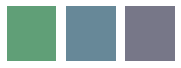

brighter green


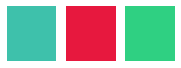

red


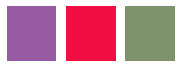

mauve


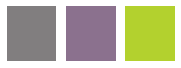

dull orange


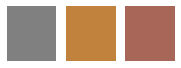

gray


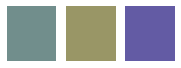

mauve or purplish pink


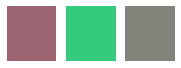

steel gray


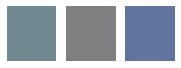

purple with hints of blue


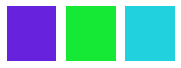

light purple


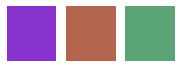

rosy dark pink


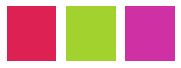

rusty orange


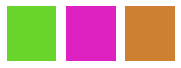

pea green


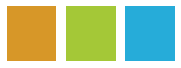

salmon


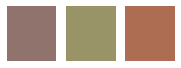

silt yellow


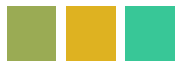

sage


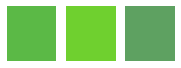

barney purple


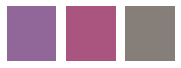

purple


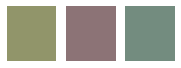

thick blue


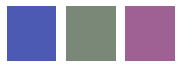

soil orange


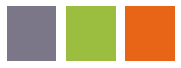

sour pink


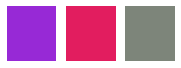

tealish green


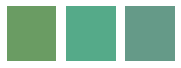

brown


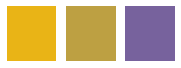

bright blue


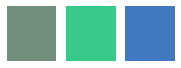

gray


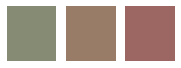

yellow


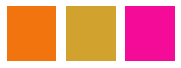

blue


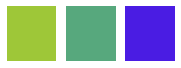

lavender


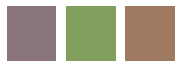

sky blue


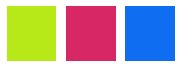

light brown


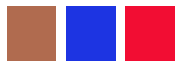

green


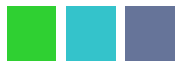

grey


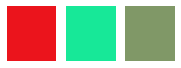

dark grey


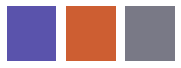

rose


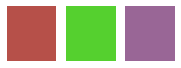

purple


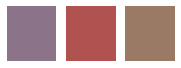

grey


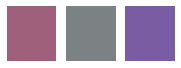

dark tan


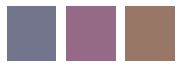

grey


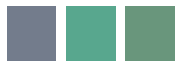

brown


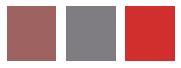

purple


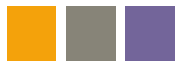

blue


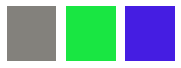

dark green


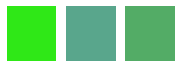

green


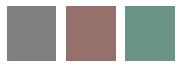

light green


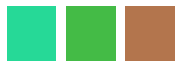

tirquoise


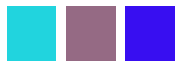

grey


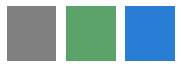

blue-grey


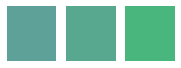

Green Gray


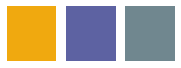

Medium Blue


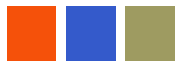

Light Gray


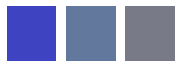

Sun Yellow


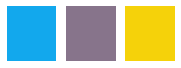

Brownish green


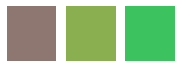

Grass green


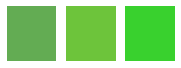

Dim Red


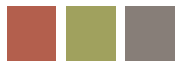

Aqua Blue


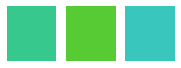

Brown Gray


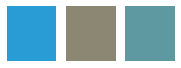

steel gray


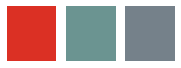

fuschia


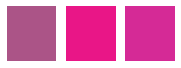

electric blue


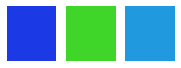

mint green


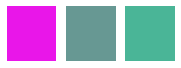

sage green


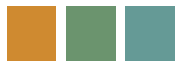

Dark Yellow


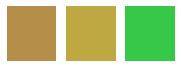

Greenish Gray


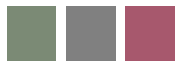

Violet


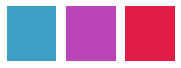

Red


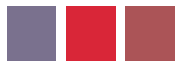

Dark Green


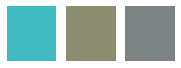

Burned Brown


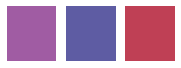

Fucsia


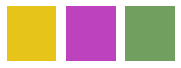

Blue


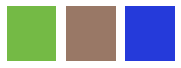

blue green


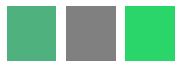

camo green


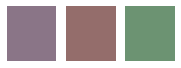

raspberry pink


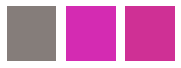

green


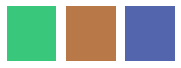

grayish green


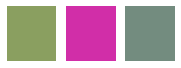

orange


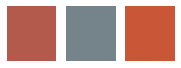

mauve


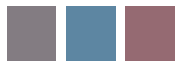

camo green


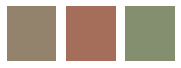

brown


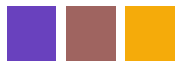

red


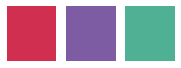

light green


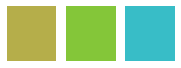

light gray


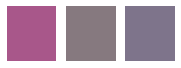

light green


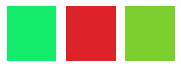

light brown


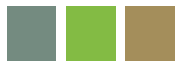

faded purple


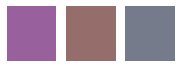

maroon


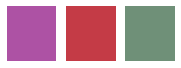

gentle pink


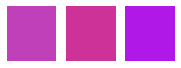

stone green


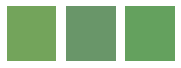

neon green


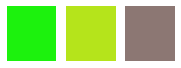

navy blue


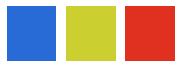

maroon


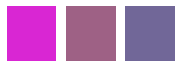

grey


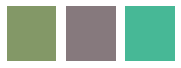

red


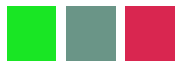

green


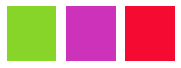

bright green


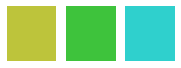

bright purple


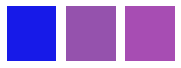

green


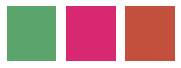

brown


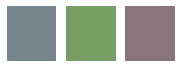

hot pink


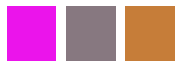

purple


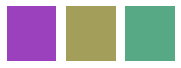

hot purple


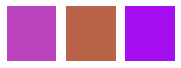

hot purple


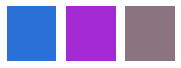

gray purple


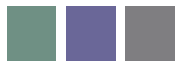

yellow orange


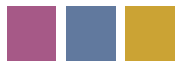

red orange


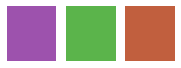

pea green


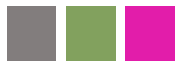

light blue


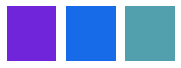

bright blue


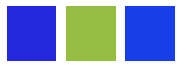

red orange


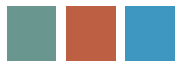

bright red brown


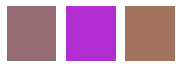

purple grey


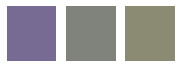

light purple


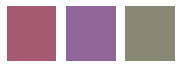

purple red


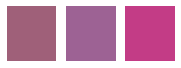

Blue


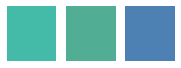

Khaki


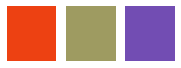

Turqouise


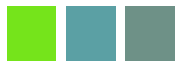

Green


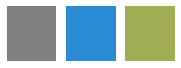

Gray


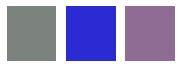

Red


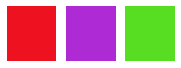

Gold


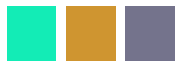

Purple


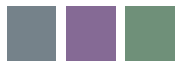

Khaki


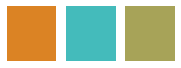

Light brown


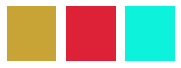

Turquoise


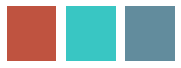

Pale Purple


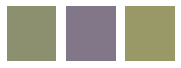

Pale Purple


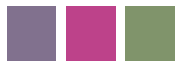

Violet


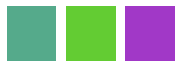

Green


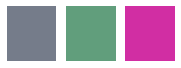

Gray


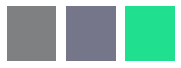

Plum


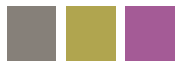

Orange


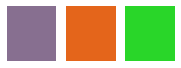

Pea Green


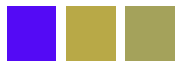

grayish blue


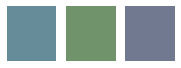

plain purple


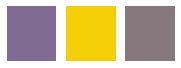

medium gray


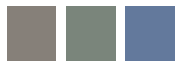

dark purple


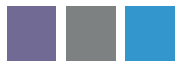

light blue


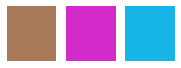

chocolate brown


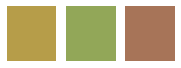

Gray


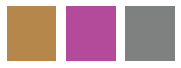

forrest green


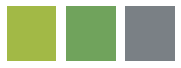

plain brown


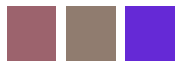

light yellow


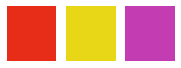

seafoam green


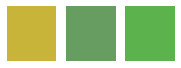

mauve


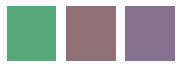

lilac


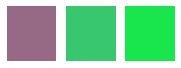

grey


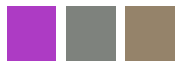

hunter green


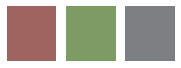

urine yellow


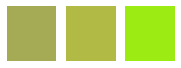

tortoisegreen


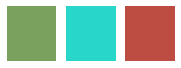

aqua blue


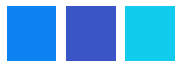

dark lavendar


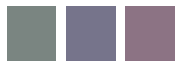

grey


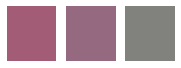

light green


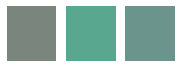

grey


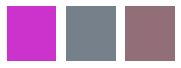

grey


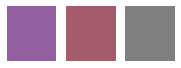

grey


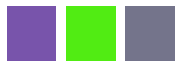

grey


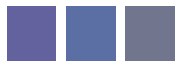

light green


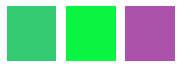

Teal


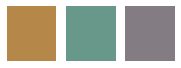

Teal


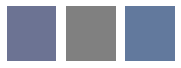

Charcoal gray


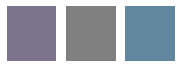

Dark gray


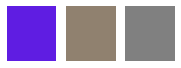

gray-green


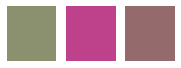

green


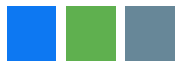

gray-green


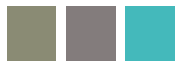

light blue


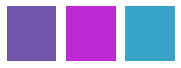

gray


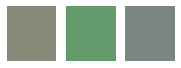

purple


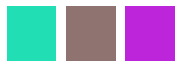

mauve


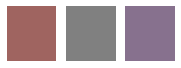

grey blue


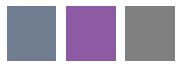

purple


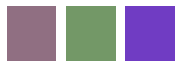

brown


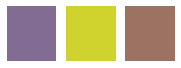

purple


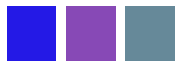

pink


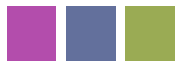

faded red


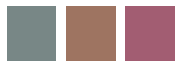

faded red


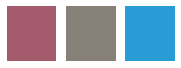

light green


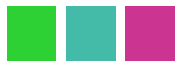

emerald green


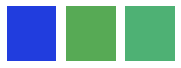

gem green


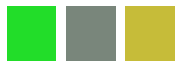

maroon


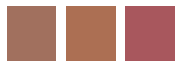

grayish green


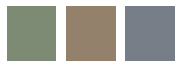

light blue


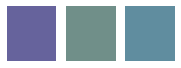

light brown


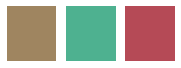

light pink


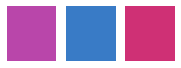

light magenta


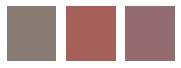

Blue


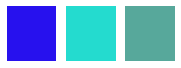

Pink


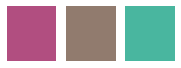

Hot Pink


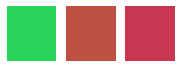

Torquise


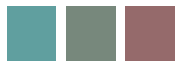

Dark Gray


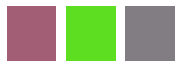

dark sage green


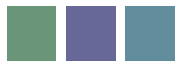

saturated kelly green


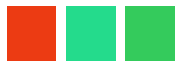

brownish red


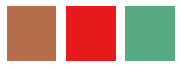

purplish blue


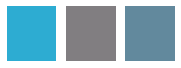

periwinkle blue


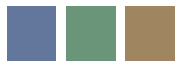

dark pale blue


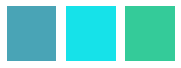

Violet


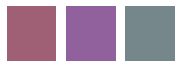

Dark Brown


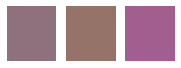

Violet


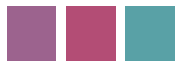

Gray


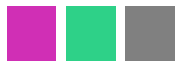

Brown


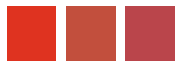

Violet


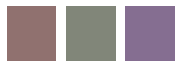

Dark Violet


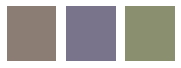

Dark green


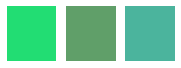

Pink


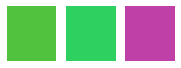

Light blue


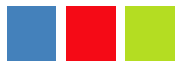

Light brownish red


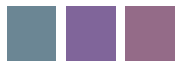

Blue


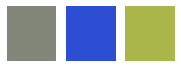

Gray


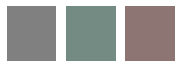

Light blue


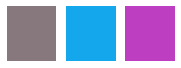

Brownish red


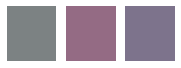

Hot pink


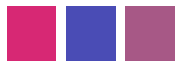

Dark gray


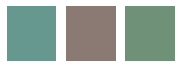

Green


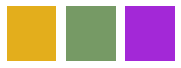

Blue


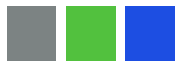

Gray


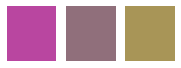

Gray


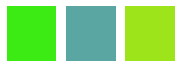

Green


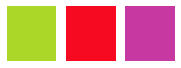

Light green


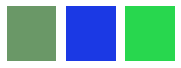

Hot pink


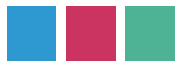

Reddish pink


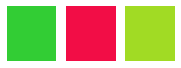

Green


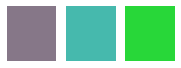

Dark gray


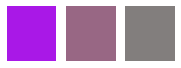

Tan


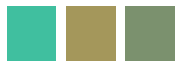

Aqua


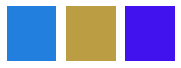

Dark gray


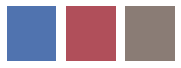

red brown


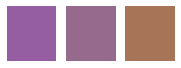

dark red brown


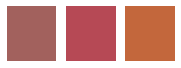

yellow green


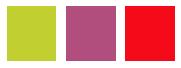

blue grey


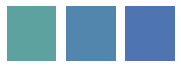

brown grey


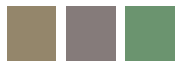

light brown grey


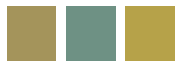

grey green


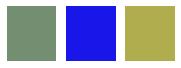

dark purple


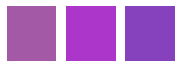

blue grey


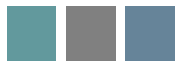

gray


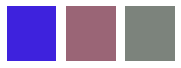

blue


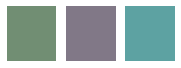

gray


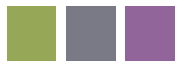

green


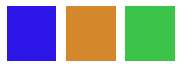

purple


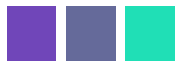

hot pink


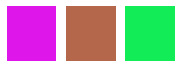

grayish purple


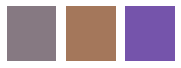

blue


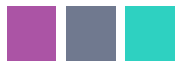

red


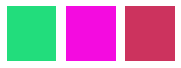

red


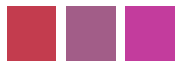

Medium gray


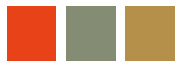

Rosy red


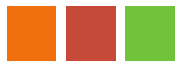

medium brown


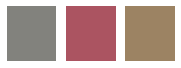

light purple


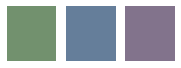

brown


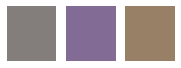

pale orange


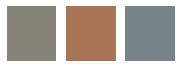

blue


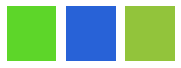

gray


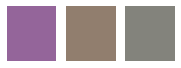

ocean blue


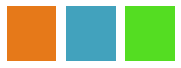

violet grey


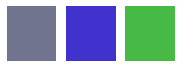

forest teal green


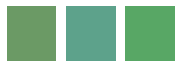

mauve


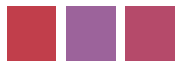

vomit yellow


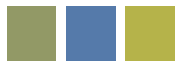

brighter blue


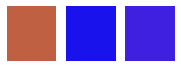

grey


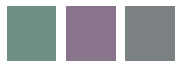

purple grey


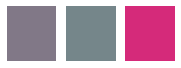

sandy brown


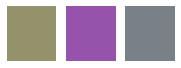

Grey or This is the result of black and white mixed together.


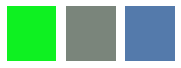

This color is grey with a greenish tint


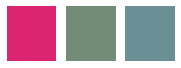

Green ; The color of fresh grass


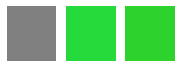

Blue the color of the sea


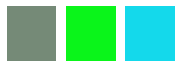

This is a brighter shade of purple


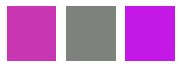

This is a lesser shade of purple.


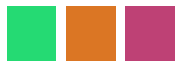

darker green


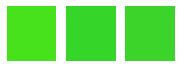

grey green


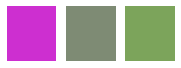

muddy green


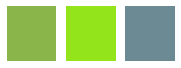

bright magenta


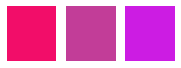

purple


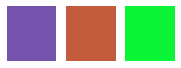

green


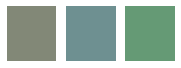

grey


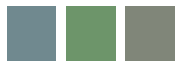

dark purple


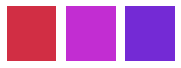

mustard


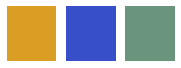

magenta


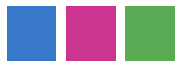

dull blue


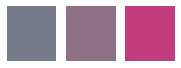

dull green


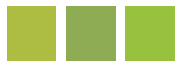

medium blue


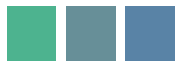

blueish purple


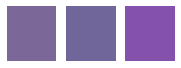

dull green


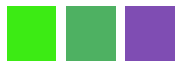

yellow


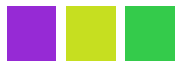

dull purple


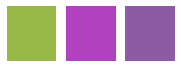

light aqua


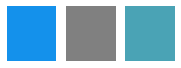

plum


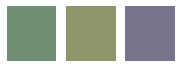

medium plum


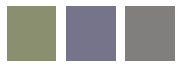

light reddish pink


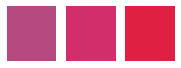

light orange


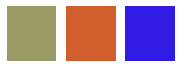

light plum


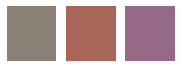

light blue


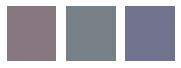

aqua


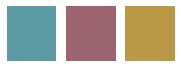

gray


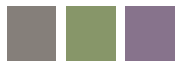

light plum


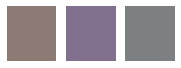

light lime


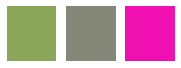

seafoam blue/green


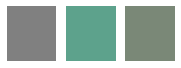

mustard


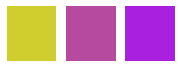

light gray


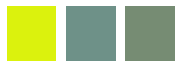

light brown


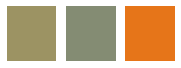

dull blue


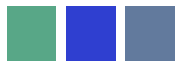

purple


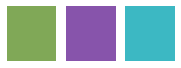

light blue


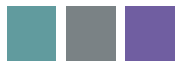

bright blue


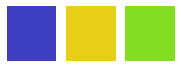

blue violet


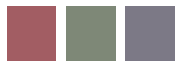

medium purple


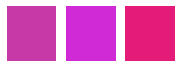

dull green


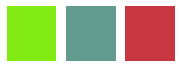

light brown


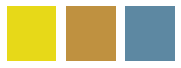

dull green


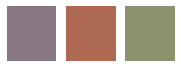

tan


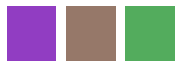

reddish pink


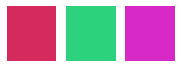

light green


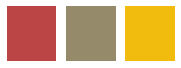

bland pink


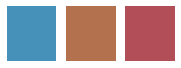

aqua


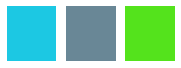

medium slate


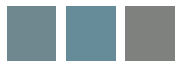

light green


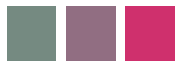

light grey


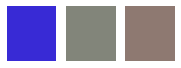

Brown


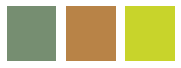

Dark purple


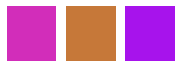

Dark Blue


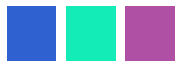

Brownish Color


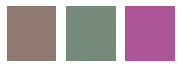

Dark Blue


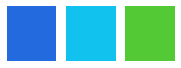

Dark Purple


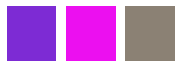

Gray


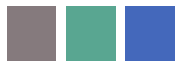

Medium green


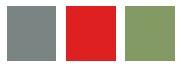

Gray


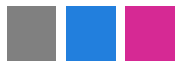

Gray


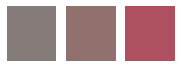

Lime Green


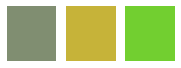

bluish purple


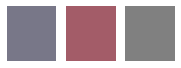

olive green


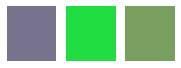

olive green


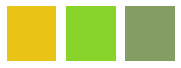

mustard


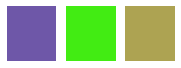

bright blue


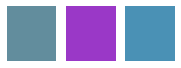

mauve


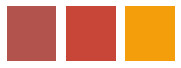

orange


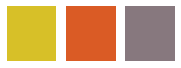

Lemon yellow


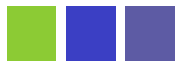

Greenish gray


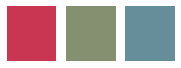

Turquoise


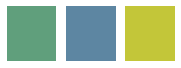

Winter blue


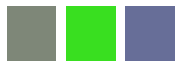

Tan


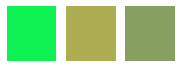

Spring green


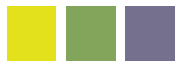

blue


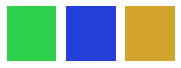

gray purple


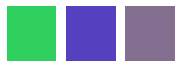

blue


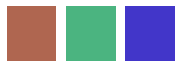

pink


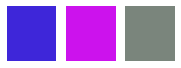

purple


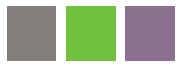

grayish pink


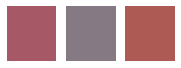

light blue


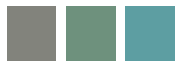

light blue


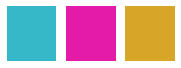

gray


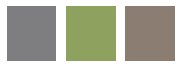

purple


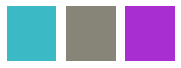

magenta


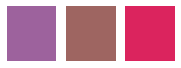

dusty rose


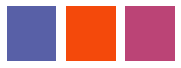

magenta


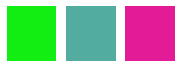

light purple


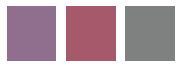

gray


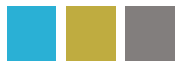

light purple


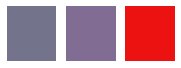

gray


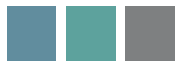

dark pink


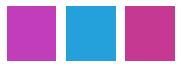

dark yellow


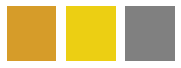

dark gray


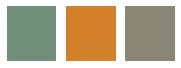

blue


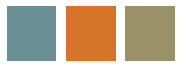

gray


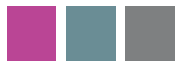

dark pink


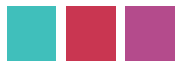

green


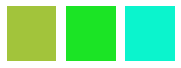

steel blue


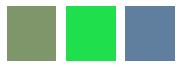

purple


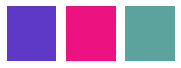

gray


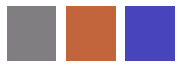

gray


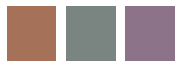

mint green


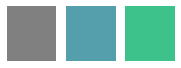

dark pink


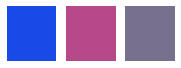

brown gray


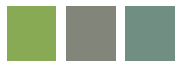

dark green


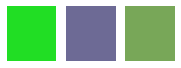

blue gray


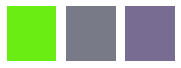

red brown


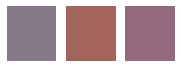

dark pink


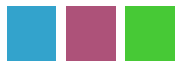

brightest green


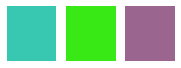

green grayish


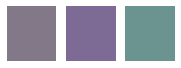

yellow gray


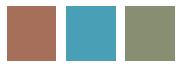

brightest pink


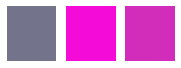

dark mauve purplish color


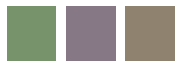

darker green that's more green than brown


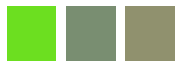

yellow


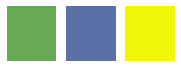

brighter pink


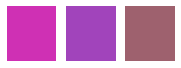

blue


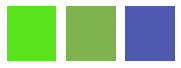

grey


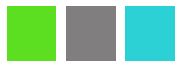

blue


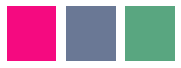

less vibrant mauve brownish


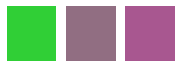

grey slate


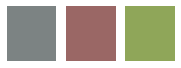

Medium dark green


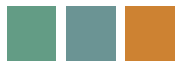

Grayish purple


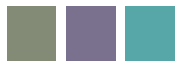

Bright green


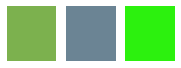

Orange


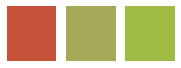

Light blueish purple


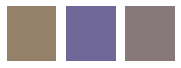

Medium dark brown


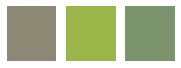

Mustard yellow


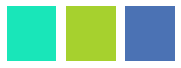

Dark blue


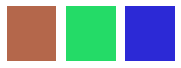

Brownish orange


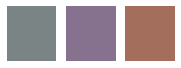

Medium pink


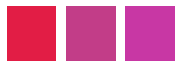

purple


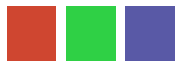

light purple


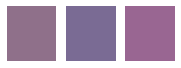

light green


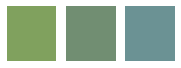

dirty yellow


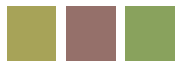

light purple


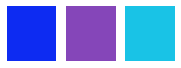

faded red


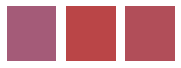

blood orange


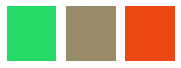

gray


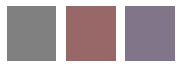

dusty blue


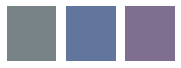

brownish gray


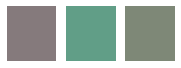

muted burnt orange


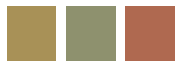

bright fuschia


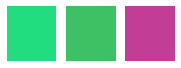

electric blue


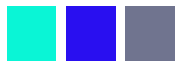

orange


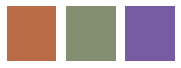

army green


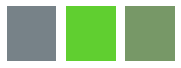

Gray


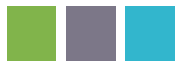

Dark Pink


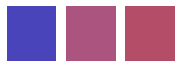

Dark Brown


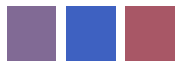

Brown


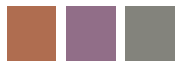

Dark Green


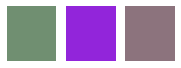

Green


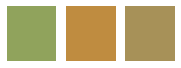

Dark Blue


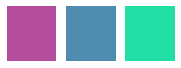

Bright Red


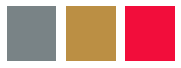

purplish gray


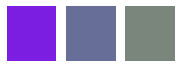

dark muted lime green


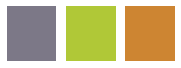

brick red


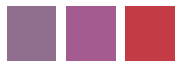

khaki green


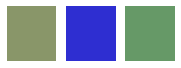

avocado green


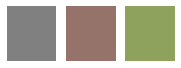

mint green


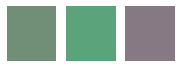

brownish green


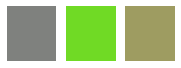

lavender


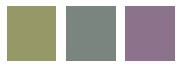

dusty lilac


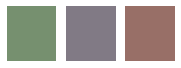

grey


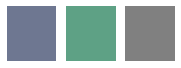

blue


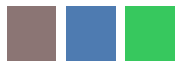

pink


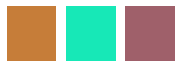

tirquoise


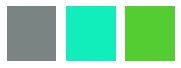

green


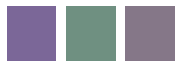

gold


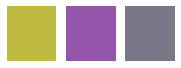

grey


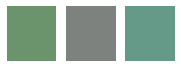

olive green


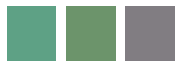

green


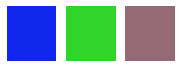

brown


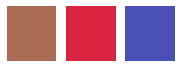

gray


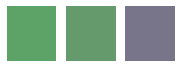

red pink


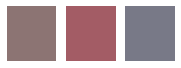

turquoise green


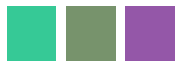

sea green


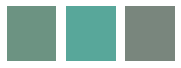

sea green


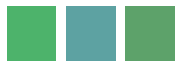

dark purple


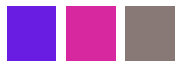

dark green


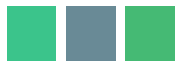

gray


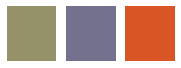

medium blue


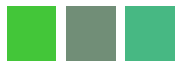

right blue


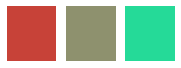

greyish green


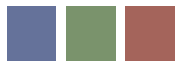

vivid green


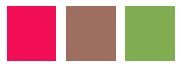

vivid blue


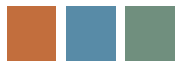

dark purple


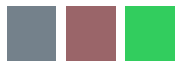

Maroon


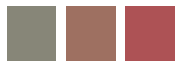

Blue and Grey Mix


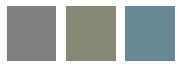

Yellow and brown mix


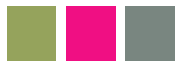

Bright Purple


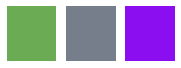

Soft light green


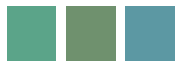

Money Green


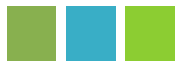

Dark orange red mix


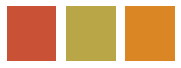

Dark Brown


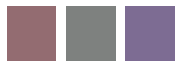

Vivid Blue


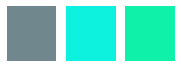

Acidic Green


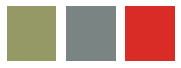

Green


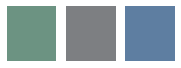

Violet


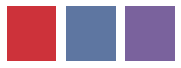

Green


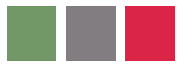

Dark Blue


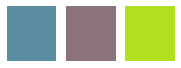

Green


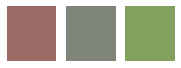

Indigo


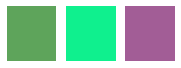

Maroon


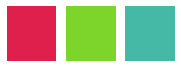

Grey


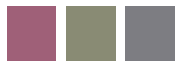

Green


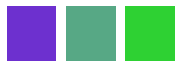

Green


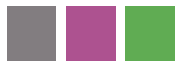

Light blue


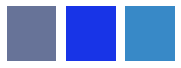

Hot pink


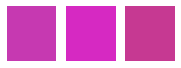

Stone grey


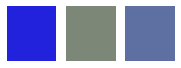

Blue grey


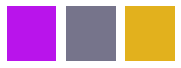

burgundy


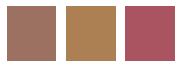

olive green


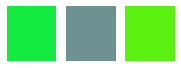

hot pink


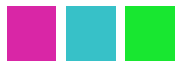

olive green


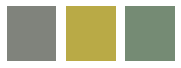

bright teal


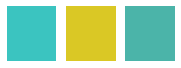

purplish gray


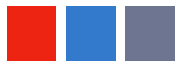

brownish gray


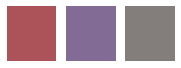

green


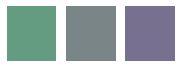

blue gray


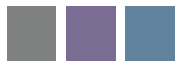

purple


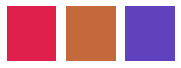

dark pink


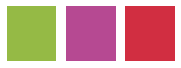

gray


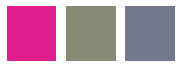

pale pink


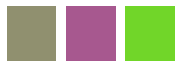

red


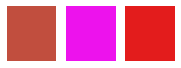

gray


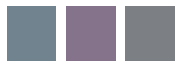

light green


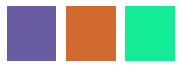

lime green


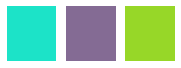

mint green


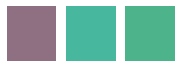

gray


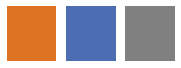

brownish red


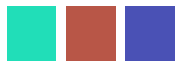

light gray


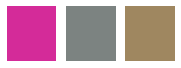

light green


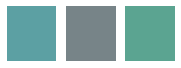

purple


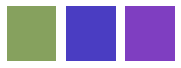

light red


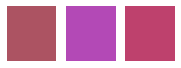

light grayish green


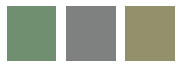

gray


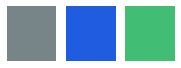

seafoam green


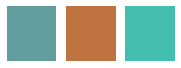

brownish pink


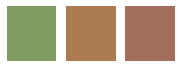

raspberry


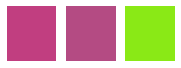

purple


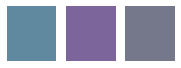

brown gray


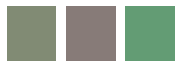

grassy green


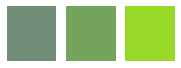

green


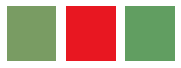

gray purple


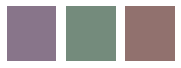

hot pink


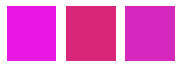

light orange


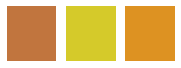

gray green


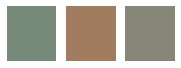

light purple


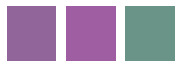

gray green


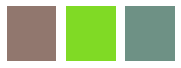

orange


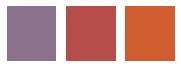

lime green


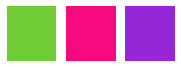

dark blue


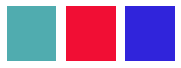

light green


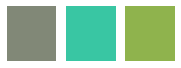

dark pink


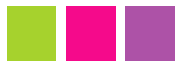

dark purple


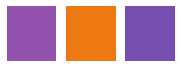

teal


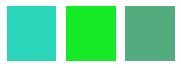

dirty green


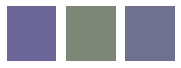

purple


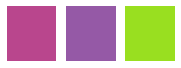

dark blue


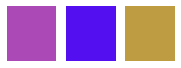

purple


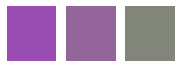

slate blue


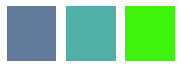

mustard yello


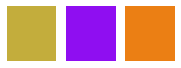

olive green


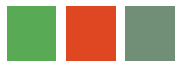

slate gray


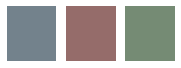

slate gray


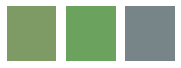

blue


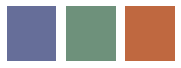

aqua green


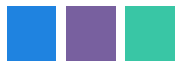

light olive


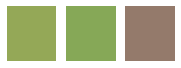

gray


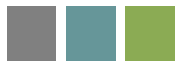

lime green


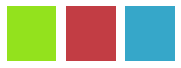

light blue


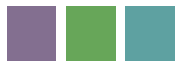

army green


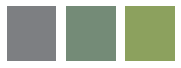

dark biege


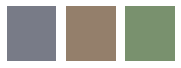

greenish gray


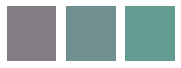

purple


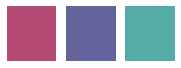

light purple


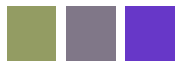

green


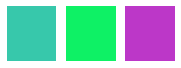

gray


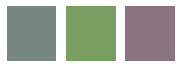

lime green


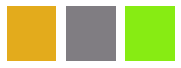

brown


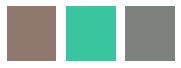

purple


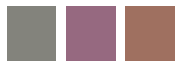

brownish purple


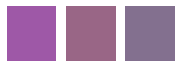

ash blue


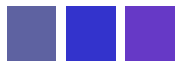

light brown


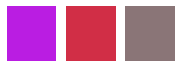

earth


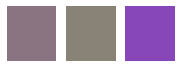

red


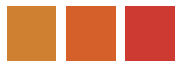

purplish blue


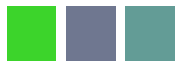

light teal


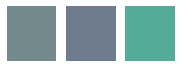

dark pink


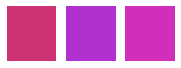

dark orange


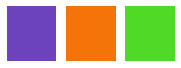

dark gray


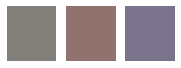

reddish pink


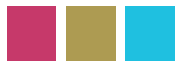

dark olive


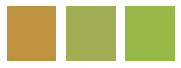

dark lavender


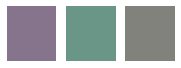

leaf green


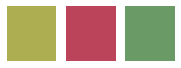

grayish purple


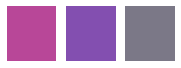

green


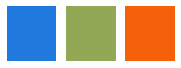

bright purple


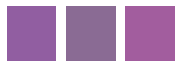

gray


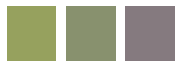

bright green


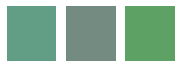

green


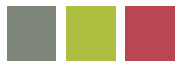

blue


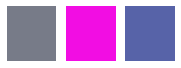

olive green


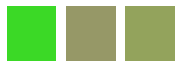

brown


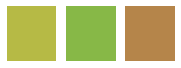

blue


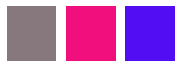

Very purple


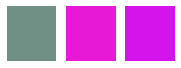

deep light blue


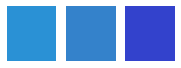

purple-grey


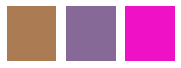

grey


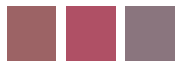

military green


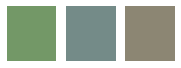

grey


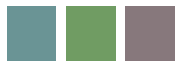

dark neon yellow


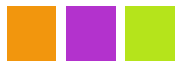

light blue


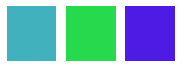

Darker Green


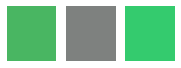

Heavy Gray


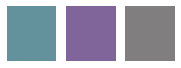

Purple


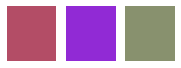

Light brown


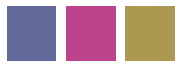

Hot Pink


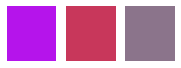

Grayish-blue


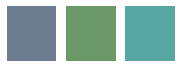

Medium Green


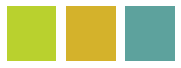

Teal


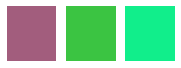

Dark Purple


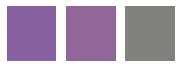

grey


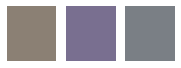

neon green


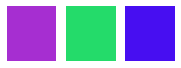

camo green


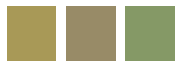

dark grey blue


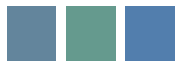

maroon


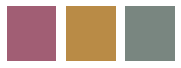

dark purple


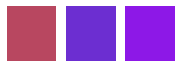

dark red


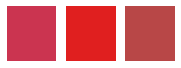

purple


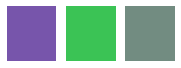

grey


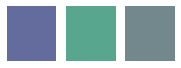

yellow


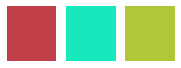

light blue


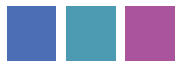

dark blue


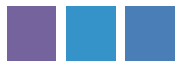

green


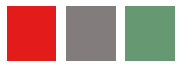

yellow


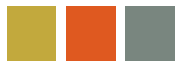

blue


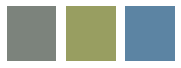

bright green


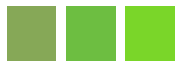

pink


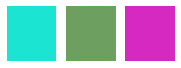

red


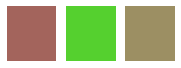

blue


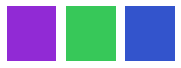

pink


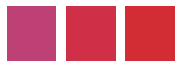

green


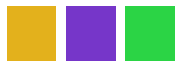

green-gray, not teal


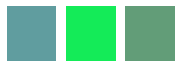

neon green


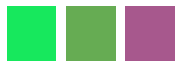

yellow


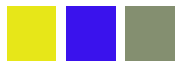

brown-gray


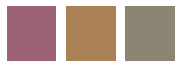

gray


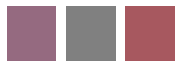

purple


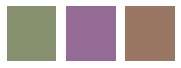

green


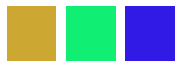

orange


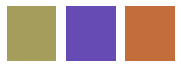

Purple


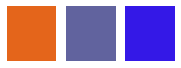

Tan


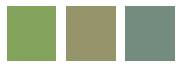

Royal, vivid purple


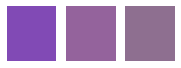

Orange


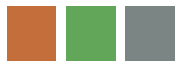

Muted, faded purple


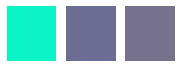

Light blue


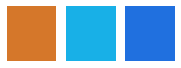

Brownish


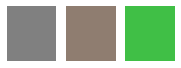

Green


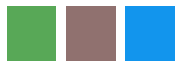

Most blue-ish green


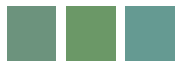

a dusty mauve


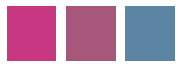

bright green


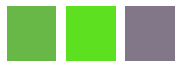

purple


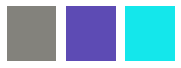

lighter hunter green


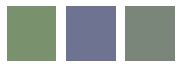

royal purple


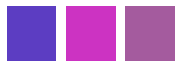

brightest, snappy green


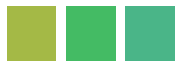

grayish purple


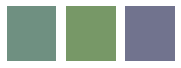

brighter green


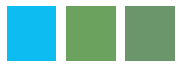

dusty mauvish


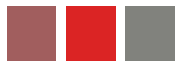

green


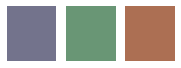

grayish green


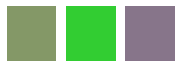

gray


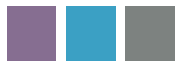

brown


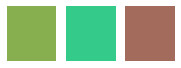

dark purple


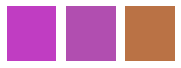

brown


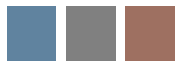

brownish gray


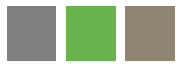

grayish purple


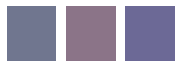

orange


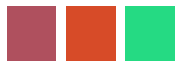

jade green


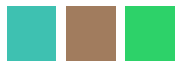

vibrant green


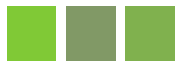

grey


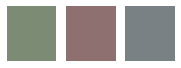

dark purple


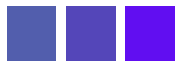

brown


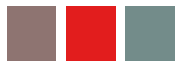

gold


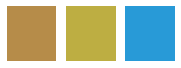

purple


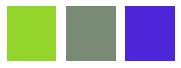

light purple


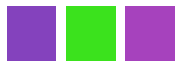

purple grey


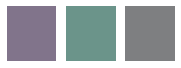

pink


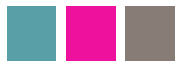

purple brown


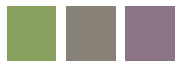

blue purple


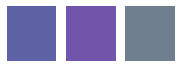

red


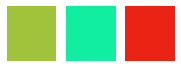

dark purple


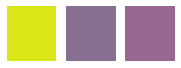

dark gray


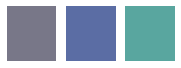

brown


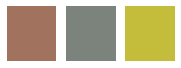

green


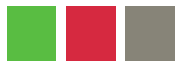

dark purple


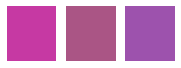

blue


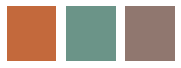

dark green


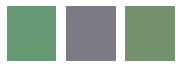

gray


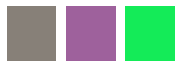

Light purple


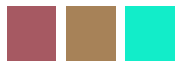

medium, blue


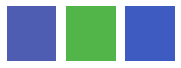

turd green


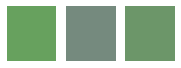

Purple


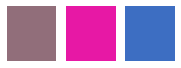

light green


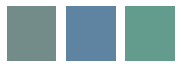

baby blue


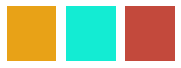

deep green


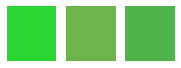

olive green


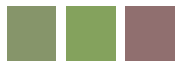

tan


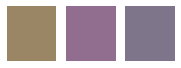

green


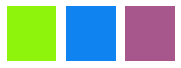

grey


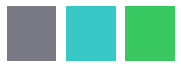

olive green


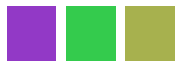

green


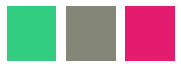

blue


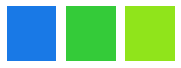

olive greeen


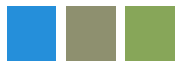

aqua blue


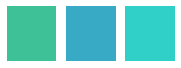

olive green


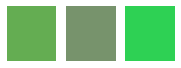

Light green


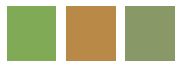

Green


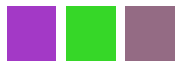

Light brown


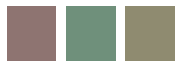

Red


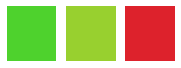

Light Red


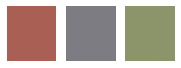

Light Brown


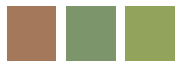

Teal


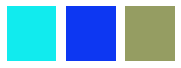

Turquoise blue


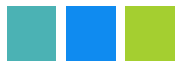

Dark Grey


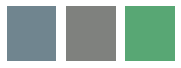

greenish blue


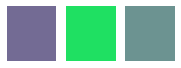

Dark Purple


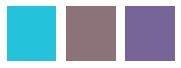

Grey


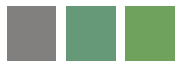

Lime Green


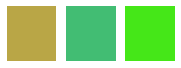

blueish green


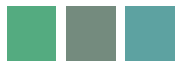

light brown


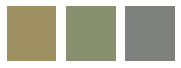

light brown


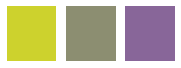

faded brown


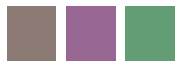

faded green


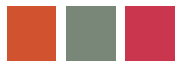

light green


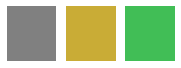

faded green


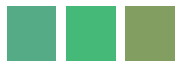

light green


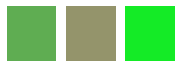

blue


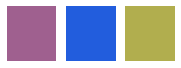

light purple


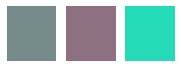

dark blue


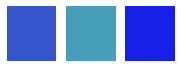

light purple


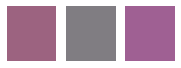

light orange


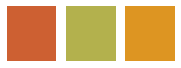

teal


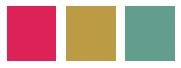

light gray


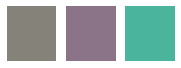

aqua


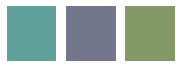

dark yellow


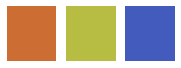

Burnt Orange


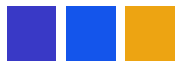

Dark Blue


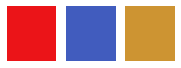

Aqua blue


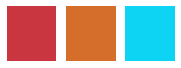

Light Grey


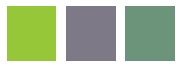

Teal Green


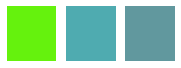

Medium Grey


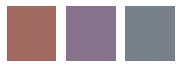

Orangey Orange


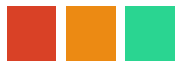

Medium Pink


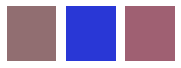

Violet purple


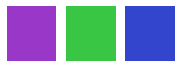

bright purple


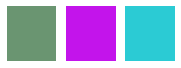

grape purple


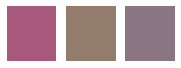

purple


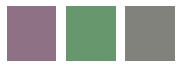

bright grass green


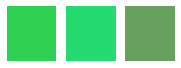

purple


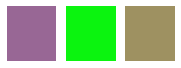

dull purple


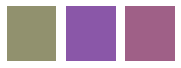

orange


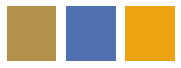

moldy green


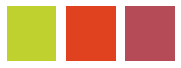

army green


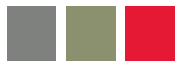

faded purple


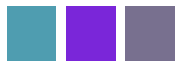

gray


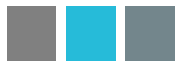

light green


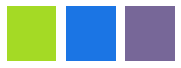

deep green


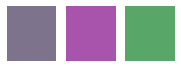

bright green


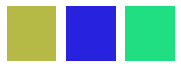

light green


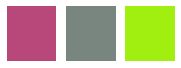

vibrant purple


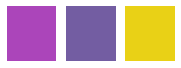

brownish red


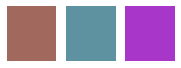

In [5]:
from colors import ColorsCorpusReader

bakeoff_src_filename = os.path.join(
    "data", "colors", "cs224u-colors-test.csv")

bakeoff_corpus = ColorsCorpusReader(bakeoff_src_filename)

key = []
for i, ex in enumerate(bakeoff_corpus.read()):
    ex.display(typ='listener', filepath=f'colors/{i}')
    #key.append(ex._get_target_index('speaker'))

In [25]:
[ex._get_target_index('listener') for ex in  bakeoff_corpus.read()]

[2,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 1,
 2,
 0,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 1,
 2,
 2,


This creates a file `cs224u-colors-bakeoff-entry.csv` in the current directory. That file should be uploaded as-is. Please do not change its name.

Only one upload per team is permitted, and you should do no tuning of your system based on what you see in the file – you should not study that file in anyway, beyond perhaps checking that it contains what you expected it to contain. The upload function will do some additional checking to ensure that your file is well-formed.

The nature of our evaluation is such that we have to release the full test set with all labels. Thus, we have to trust you not to make any use of the test set during development. Recall:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.

Systems will be ranked primarily by `listener_accuracy`, but we will also consider their `corpus_bleu` scores. However, the BLEU score is just a simple check that your system is speaking some version of English that corresponds in some meaningful way to the gold descriptions, so you should concentrate on `listener_accuracy`.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points.

## Submission Instruction

Review and follow the [Homework and bake-off code: Formatting guide](hw_formatting_guide.ipynb).
Please do not change the file name as described below.

Submit the following files to Gradescope:

- `hw_colors.ipynb` (this notebook)
- `cs224u-colors-bakeoff-entry.csv` (bake-off output)